# Objective

The final TFR pipeline

In [1]:
# importations
import mne, fooof, numpy as np, pandas as pd, os, glob, sys
from mne.preprocessing import ICA
from IPython.display import display, Markdown
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import zscore

In [50]:
# defining preset vars
# processed_dir = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/bme1500/preprocessed_final'

processed_dir = r'G:\My Drive\Lab\other_projects\bme1500\preprocessed_final'

#save_dir = 'C:/Users/Parsa/Lab/other_projects/bme1500/tfr_pickles/'

freqs = np.logspace(*np.log10([1, 250]), num=125)

tfr_kwargs = dict(vmin=-2 *1e-9, vmax=2 *1e-9)

base_evs = np.array([[ 2000,      0,      1],
   [ 4000,      0,      1],
   [ 6000,      0,      1],
   [ 8000,      0,      1],
   [ 10000,      0,      1],
   [ 12000,      0,      1],
   [ 14000,      0,      1],
   [ 16000,      0,      1],
   [ 18000,      0,      1],
   [ 20000,      0,      1]])

freq_ticks = [' '] * 125
for n, i in enumerate(freq_ticks):
    if n in np.arange(0, 125, 10):
        freq_ticks[n] = np.around(freqs, decimals=2)[n]

In [5]:
def give_me_all_tfrs(tfr, ch):
    all_tr_tfrs = dict()
    dat = tfr.copy().pick_channels([ch]).data
    for n, tr in enumerate(dat):
        all_tr_tfrs[n] = tr[0]
    return all_tr_tfrs
    

In [6]:
def give_me_tfr_dict(epochs, average=False):
    
    freqs = np.logspace(*np.log10([1, 250]), num=125)
    n_cycles = freqs / 2.  # different number of cycle per frequency


    power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?
                            return_itc=False, decim=3, n_jobs=-1,
                                              average=average)
    
    just_everything = dict()
    chs = epochs.ch_names
    i=0
    for ch in chs:
        print(f'Working on channel {ch}, {i}')
        i+=1
        just_everything[ch] = give_me_all_tfrs(power, ch)
        
        avg = np.zeros_like(just_everything[ch][0])
        for n in just_everything[ch]:
            avg += just_everything[ch][n]
        avg = avg/len(just_everything[ch])
        just_everything[ch]['avg'] = avg
        
    return just_everything, power

In [30]:
def pickle_me_tfrs(sub, epochs_dir=processed_dir, save_dir=save_dir):
    files = sorted(glob.glob(f'{epochs_dir}*{sub}*final*fif'))
    for block in files:
        ses_name = block.split('/')[-1][:-8]
        print(ses_name)
        epochs = mne.read_epochs(processed_dir+ses_name+'-epo.fif')
        just_everything = give_me_tfr_dict(epochs)
        with open(save_dir+ses_name+'.pkl', 'wb') as f:
            pickle.dump(just_everything, f)
        del f
        del just_everything

NameError: name 'save_dir' is not defined

In [7]:
def gimmi_base_eps_for_tfr(raw):
    new_raw1 = demean(raw)
    new_raw2 = new_raw1.copy().filter(5, 250)
    new_raw3 = new_raw2.copy().set_eeg_reference(ref_channels='average')
    sel_chans = ['FC5', 'FC3', 'FC1', 'C5', 'C3', 'C1', 'CP5', 'CP3', 'CP1']
    cut_raw0 = new_raw3.copy().pick_channels(sel_chans)
    cut_raw0.crop(tmax=20)
    base_evs = np.array([[ 10000,      0,      1],
       [ 20000,      0,      1],
       [ 30000,      0,      1],
       [ 40000,      0,      1],
       [ 50000,      0,      1],
       [ 60000,      0,      1],
       [ 70000,      0,      1],
       [ 80000,      0,      1],
       [ 90000,      0,      1],
       [100000,      0,      1]])
    base_eps0 = mne.Epochs(cut_raw0, events, tmin=-0.1, tmax=1.8, baseline=None)
    base_eps0.load_data()
    base_eps0.pick_types(eeg=True)
    base_eps0.resample(1000)
    print('reject bad epochs then call "give_me_tfr_dict"!')
    return base_eps0

In [8]:
def demean(raww):
    raw = raww.copy()
    raw_dat = raw.pick_types(eeg=True).get_data()
    raw_dat_demean = np.zeros_like(raw_dat)
    for ch, chan_data in enumerate(raw_dat):
        raw_dat_demean[ch] = raw_dat[ch] - raw_dat[ch].mean()   

    new_raw1 = mne.io.RawArray(raw_dat_demean, raw.pick_types(eeg=True).info)
    return new_raw1

In [11]:
def remove_bands(diff):
    _diff = diff.copy()
    _diff[86:91, :] = 0
    _diff[108:111, :] = 0
    return _diff

In [47]:
# step 1: get the difference between matrices

def get_diff(cond_mat, ctrl_mat, freqs=freqs, plot=False, tfr_kwargs=tfr_kwargs):
    
    diff = cond_mat - ctrl_mat
    diff = remove_bands(diff)
    
    if plot:
        fig, ax = plt.subplots(nrows=3, figsize=(7, 16))

        sns.heatmap(cond_mat, cmap='RdBu_r', yticklabels=freq_ticks, ax=ax[0], **tfr_kwargs)
        ax[0].set_title('stim')
        ax[0].invert_yaxis()

        sns.heatmap(ctrl_mat, cmap='RdBu_r', yticklabels=freq_ticks, ax=ax[1], **tfr_kwargs)
        ax[1].set_title('ctrl')
        ax[1].invert_yaxis()


        sns.heatmap(diff, cmap='RdBu_r', yticklabels=freq_ticks, ax=ax[2], **tfr_kwargs)
        ax[2].set_title('diff')
        ax[2].invert_yaxis()

        plt.tight_layout()
        plt.show()
    return diff
                

In [10]:
def zscore_and_thresh(diff, thr=2.0, plot=False):
    t = zscore(diff)
    t_thr = t.copy()
    t_thr[np.abs(t_thr)<thr] = 0
    if plot:
        fig, ax = plt.subplots(nrows=2, figsize=(8, 14))
        sns.heatmap(t, cmap='viridis', yticklabels=freq_ticks, ax=ax[0], vmax=2, vmin=-2)#, center=0)
        ax[0].set_title('zscored')
        ax[0].invert_yaxis()

        sns.heatmap(t_thr, cmap='viridis', yticklabels=freq_ticks, ax=ax[1], vmax=2, vmin=-2)#, center=0)
        ax[1].set_title(f'thr at {thr}');
        ax[1].invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    return t, t_thr

In [ ]:
def get_ctrl_cond_mats(base_epochs, task_epochs, per_trial=False):
    tfr_base, pwr_base = give_me_tfr_dict(base_epochs, average=True)
    ctrl_mat = pwr_base.data.mean(axis=0)
    
    
    if per_trial:
        tfr_task, pwr_task = give_me_tfr_dict(task_epochs, average=False)
        cond_mat = np.zeros_like(tfr_task['FC3'][0])
        for key in tfr_task.keys():
            cond_mat += tfr_task[key][6] # the 6th epoch chosen at random
        cond_mat = cond_mat/len(tfr_task.keys())
    else:
        tfr_task, pwr_task = give_me_tfr_dict(task_epochs, average=True)
        cond_mat = pwr_task.data.mean(axis=0)
    
    return ctrl_mat, cond_mat

## Step 1: import sub raw file (for sub 22)

In [38]:
sub = 'sub22'
ses = 0

In [39]:
# loading baseline
base_raw_fnames = sorted(glob.glob(processed_dir + f'/{sub}*baseline-raw.fif'))
base_raw_fnames

['G:\\My Drive\\Lab\\other_projects\\bme1500\\preprocessed_final\\sub22_ses00_baseline-raw.fif',
 'G:\\My Drive\\Lab\\other_projects\\bme1500\\preprocessed_final\\sub22_ses01_baseline-raw.fif',
 'G:\\My Drive\\Lab\\other_projects\\bme1500\\preprocessed_final\\sub22_ses02_baseline-raw.fif',
 'G:\\My Drive\\Lab\\other_projects\\bme1500\\preprocessed_final\\sub22_ses03_baseline-raw.fif',
 'G:\\My Drive\\Lab\\other_projects\\bme1500\\preprocessed_final\\sub22_ses04_baseline-raw.fif',
 'G:\\My Drive\\Lab\\other_projects\\bme1500\\preprocessed_final\\sub22_ses05_baseline-raw.fif',
 'G:\\My Drive\\Lab\\other_projects\\bme1500\\preprocessed_final\\sub22_ses06_baseline-raw.fif',
 'G:\\My Drive\\Lab\\other_projects\\bme1500\\preprocessed_final\\sub22_ses07_baseline-raw.fif',
 'G:\\My Drive\\Lab\\other_projects\\bme1500\\preprocessed_final\\sub22_ses08_baseline-raw.fif',
 'G:\\My Drive\\Lab\\other_projects\\bme1500\\preprocessed_final\\sub22_ses09_baseline-raw.fif',
 'G:\\My Drive\\Lab\\other_pro

In [19]:
base_raw = mne.io.read_raw(base_raw_fnames[ses])

Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub00_ses00_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.


In [40]:
# loading task epochs
task_eps_fnames = sorted(glob.glob(processed_dir + f'/{sub}*2-epo.fif'))
task_eps_fnames

['G:\\My Drive\\Lab\\other_projects\\bme1500\\preprocessed_final\\sub22_ses00_final_2-epo.fif',
 'G:\\My Drive\\Lab\\other_projects\\bme1500\\preprocessed_final\\sub22_ses01_final_2-epo.fif',
 'G:\\My Drive\\Lab\\other_projects\\bme1500\\preprocessed_final\\sub22_ses02_final_2-epo.fif',
 'G:\\My Drive\\Lab\\other_projects\\bme1500\\preprocessed_final\\sub22_ses03_final_2-epo.fif',
 'G:\\My Drive\\Lab\\other_projects\\bme1500\\preprocessed_final\\sub22_ses04_final_2-epo.fif',
 'G:\\My Drive\\Lab\\other_projects\\bme1500\\preprocessed_final\\sub22_ses05_final_2-epo.fif',
 'G:\\My Drive\\Lab\\other_projects\\bme1500\\preprocessed_final\\sub22_ses06_final_2-epo.fif',
 'G:\\My Drive\\Lab\\other_projects\\bme1500\\preprocessed_final\\sub22_ses07_final_2-epo.fif',
 'G:\\My Drive\\Lab\\other_projects\\bme1500\\preprocessed_final\\sub22_ses08_final_2-epo.fif',
 'G:\\My Drive\\Lab\\other_projects\\bme1500\\preprocessed_final\\sub22_ses09_final_2-epo.fif',
 'G:\\My Drive\\Lab\\other_projects\\bme

# Step 2: select channels

In [20]:
sel_chans = ['FC5', 'FC3', 'FC1', 'C5', 'C3', 'C1', 'CP5', 'CP3', 'CP1']
base_raw.pick_channels(sel_chans)

<Raw | sub00_ses00_baseline-raw.fif, 9 x 20001 (20.0 s), ~42 kB, data not loaded>

In [25]:
## Step 3: epoch

In [64]:
base_eps = mne.Epochs(base_raw, base_evs, tmin=-0.1, tmax=1.8, baseline=None)

Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated


In [28]:
# Step 4: comparing stim on vs off IN SAME SESS

In [44]:
# base_tfr, base_pwr = give_me_tfr_dict(base_eps, average=True)

In [65]:
task_eps = mne.read_epochs(task_eps_fnames[ses])
task_eps.pick_channels(sel_chans)

Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses00_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated


Number of events,26
Events,1: 12: 25
Time range,-0.100 – 1.800 sec
Baseline,off


In [45]:
# task_tfr, task_pwr = give_me_tfr_dict(task_eps, average=False)

In [66]:
base_eps.load_data()
task_eps.load_data()

base_eps.filter(l_freq=6, h_freq=None)
task_eps.filter(l_freq=6, h_freq=None)

Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 6 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 sec)

Setting up high-pass filter at 6 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 sec)



Number of events,26
Events,1: 12: 25
Time range,-0.100 – 1.800 sec
Baseline,off


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


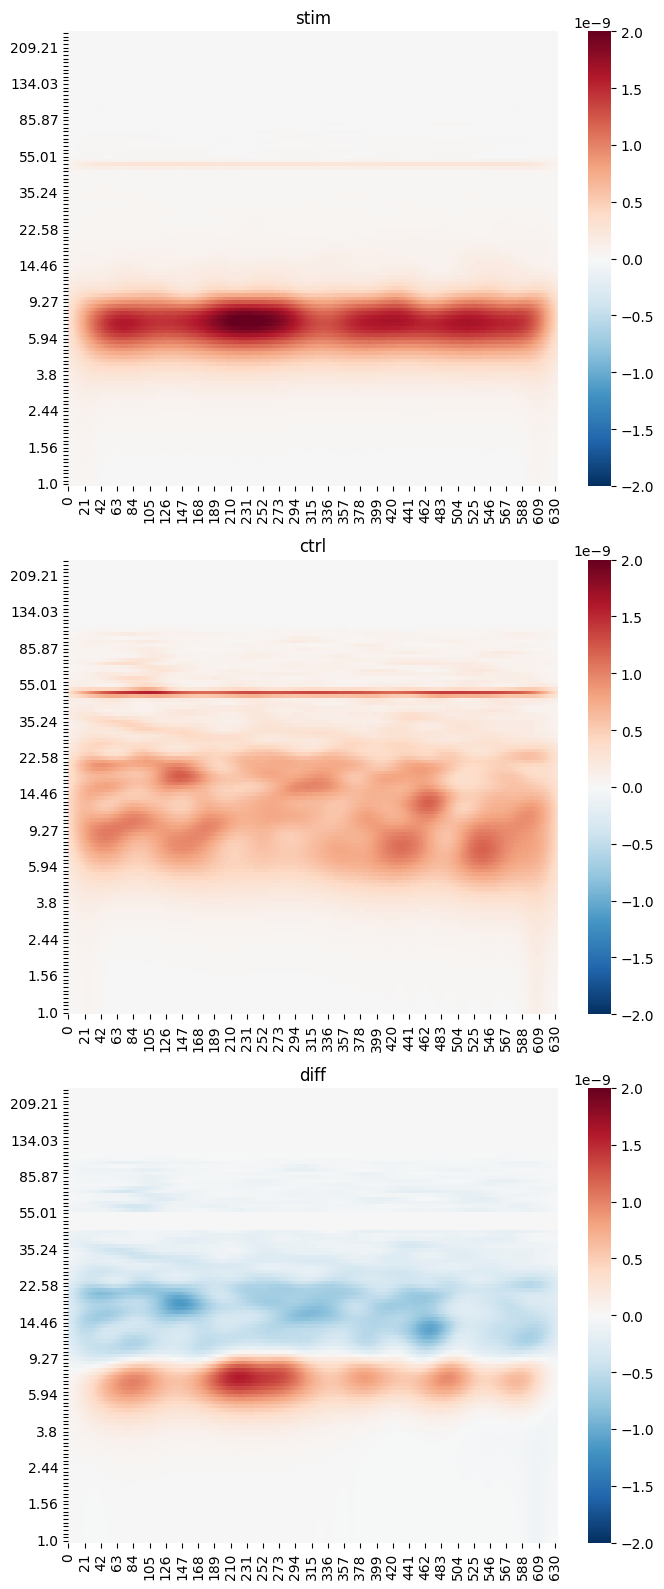

In [67]:
# get diff
ctrl_mat, cond_mat = get_ctrl_cond_mats(base_eps, task_eps, per_trial=False)
diff = get_diff(cond_mat, ctrl_mat, plot=True)

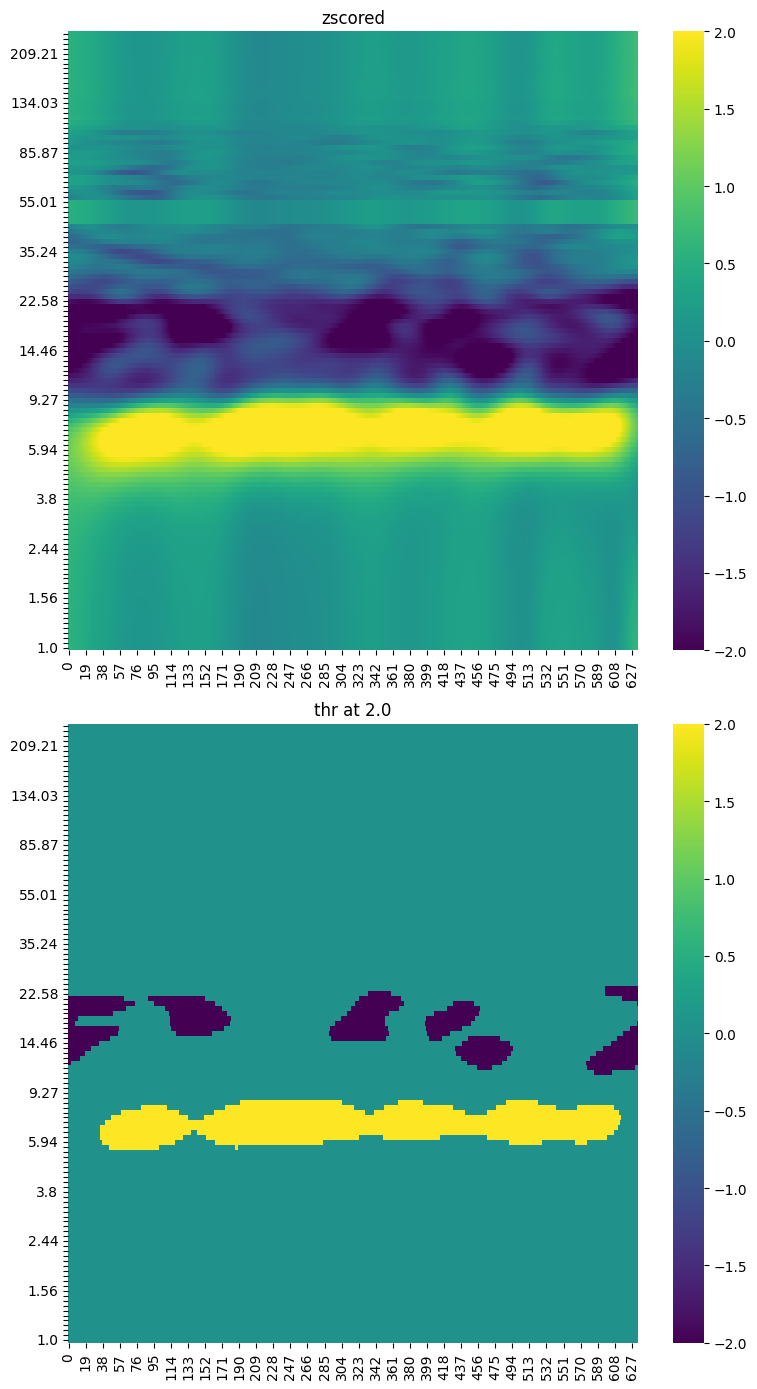

In [68]:
z_mat, z_mat_thr = zscore_and_thresh(diff, thr=2.0, plot=True)

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Not setting metadata
Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


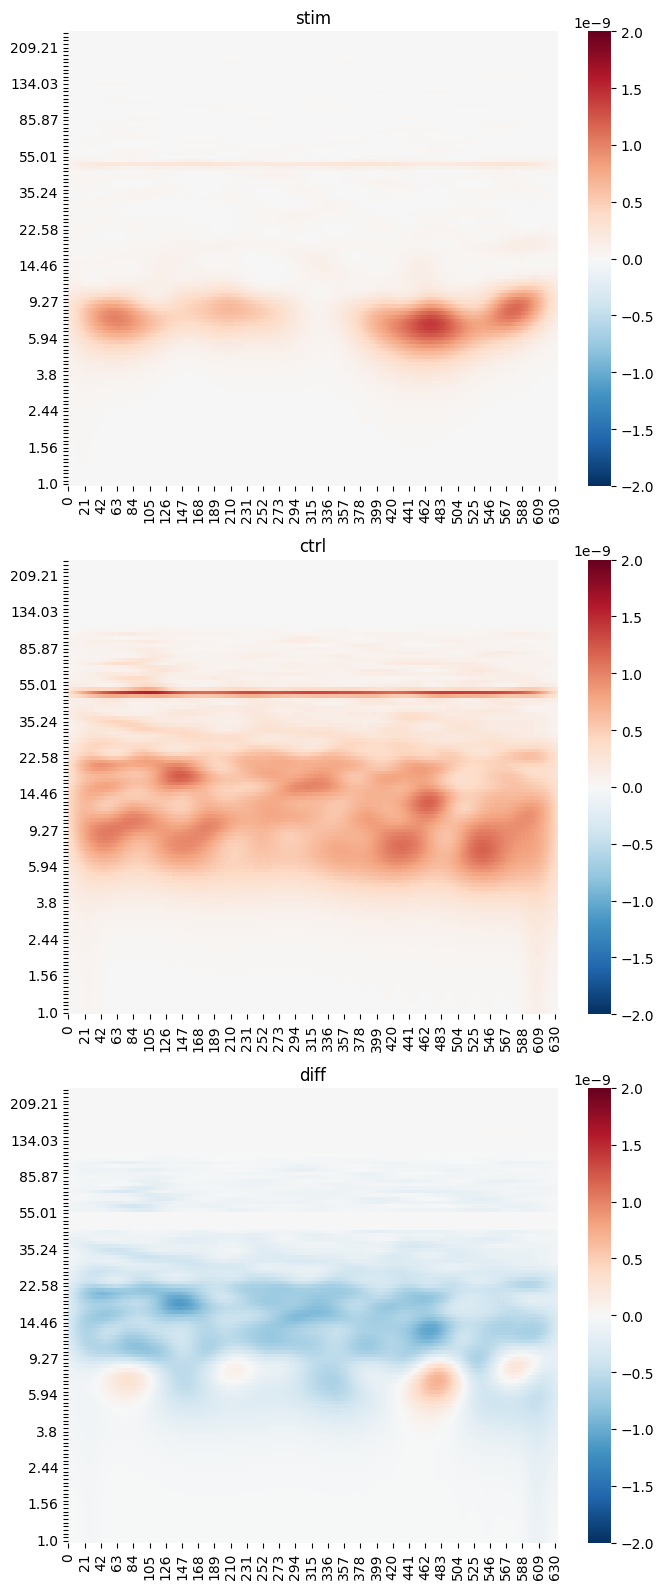

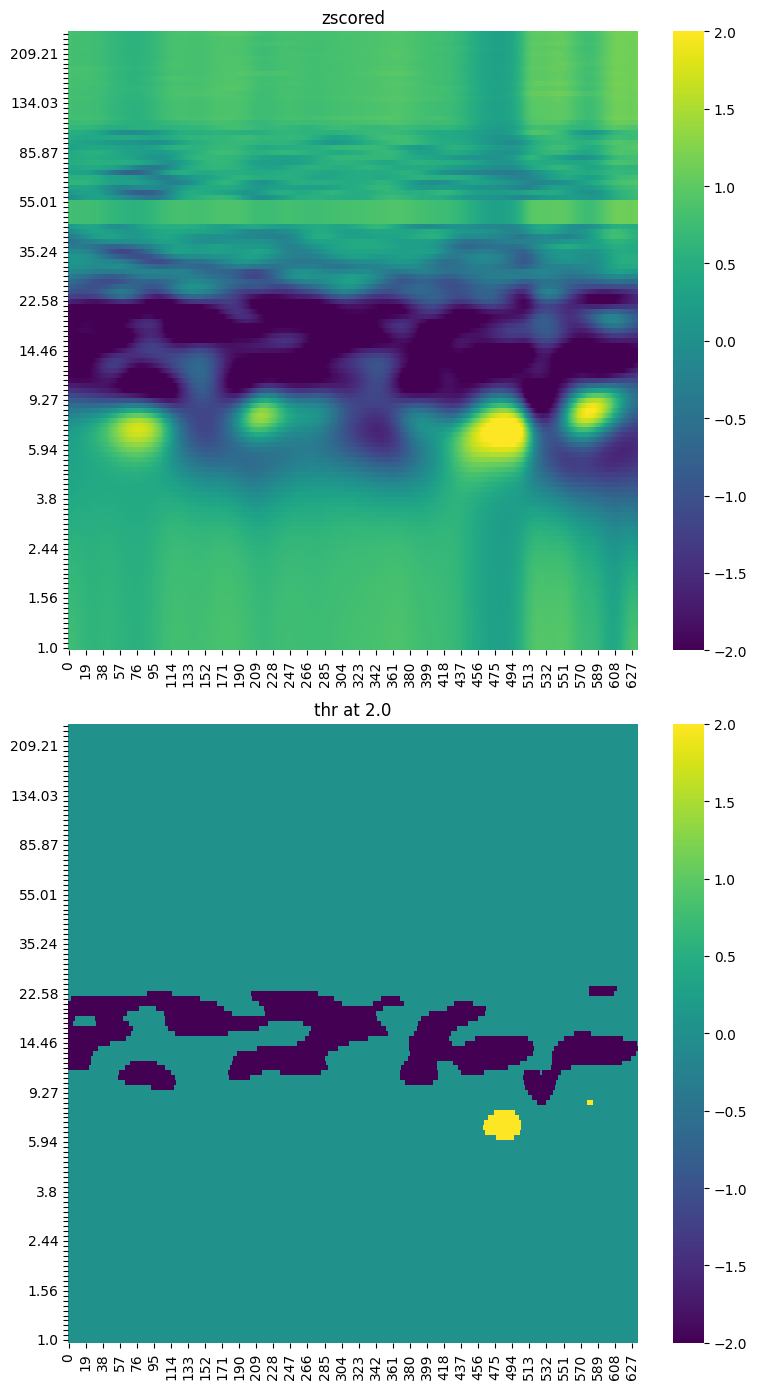

In [69]:
# per trial basis

tr_ctrl_mat, tr_cond_mat = get_ctrl_cond_mats(base_eps, task_eps, per_trial=True)
tr_diff = get_diff(tr_cond_mat, tr_ctrl_mat, plot=True)
tr_z_mat, tr_z_mat_thr = zscore_and_thresh(tr_diff, thr=2.0, plot=True)

In [126]:
# now dumping everything into one fcn

def get_fif_give_zmat(sub, ses, sel_chans, per_trial=False, thr=1.64, plot=True):
    
    # loading baseline
    base_raw_fnames = sorted(glob.glob(processed_dir + f'/{sub}*baseline-raw.fif'))
    base_raw = mne.io.read_raw(base_raw_fnames[ses])
    base_raw.pick_channels(sel_chans)

    base_eps = mne.Epochs(base_raw, base_evs, tmin=-0.1, tmax=1.8, baseline=None)

    # loading task epochs
    task_eps_fnames = sorted(glob.glob(processed_dir + f'/{sub}*2-epo.fif'))
    task_eps = mne.read_epochs(task_eps_fnames[ses])
    task_eps.pick_channels(sel_chans)

    base_eps.load_data()
    task_eps.load_data()

    base_eps.filter(l_freq=12.5, h_freq=None)
    task_eps.filter(l_freq=12.5, h_freq=None)

    # get diff
    ctrl_mat, cond_mat = get_ctrl_cond_mats(base_eps, task_eps, per_trial=per_trial)
    diff = get_diff(cond_mat, ctrl_mat, plot=plot)
    z_mat, z_mat_thr = zscore_and_thresh(diff, thr=thr, plot=plot)
    
    del base_raw
    del base_eps
    del task_eps
    
    return ctrl_mat, cond_mat, diff, z_mat, z_mat_thr


# Testing it out!

Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses05_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses05_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.50
- Lower transition 

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


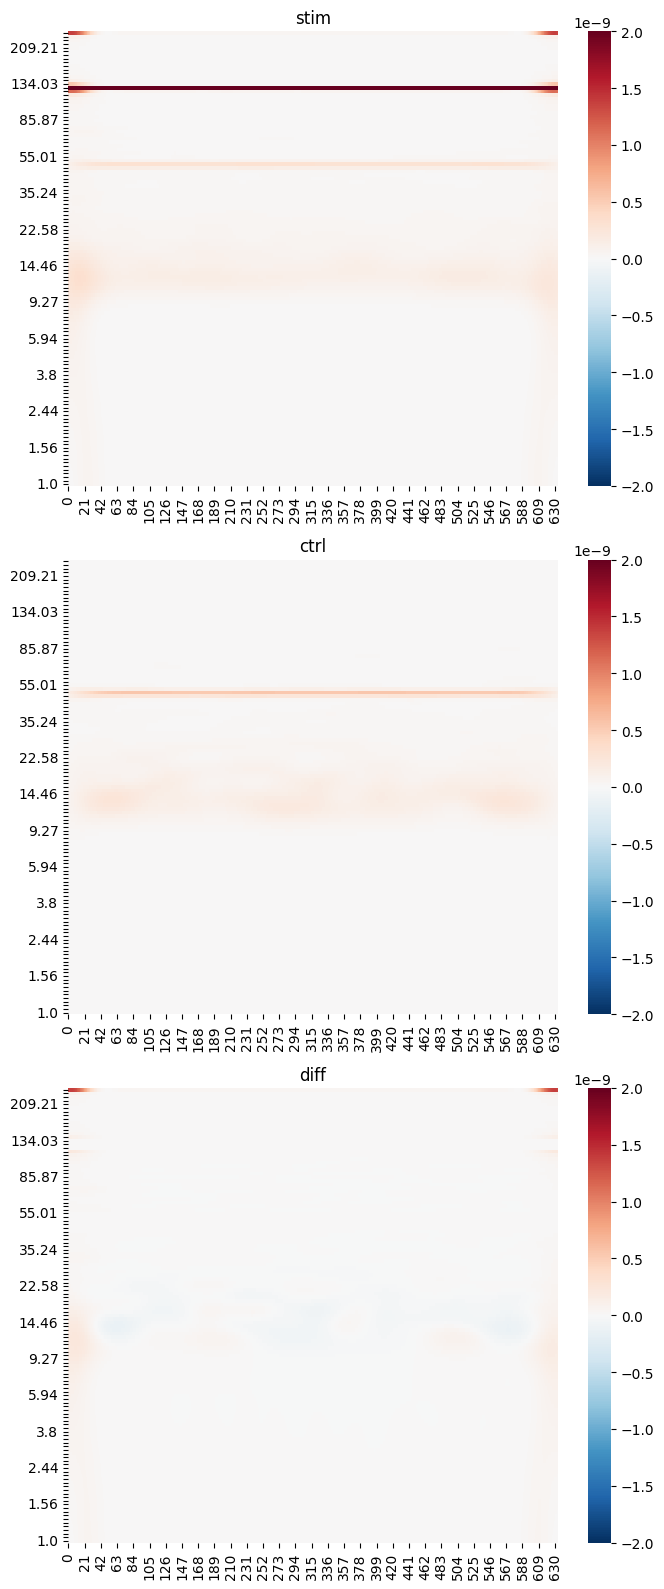

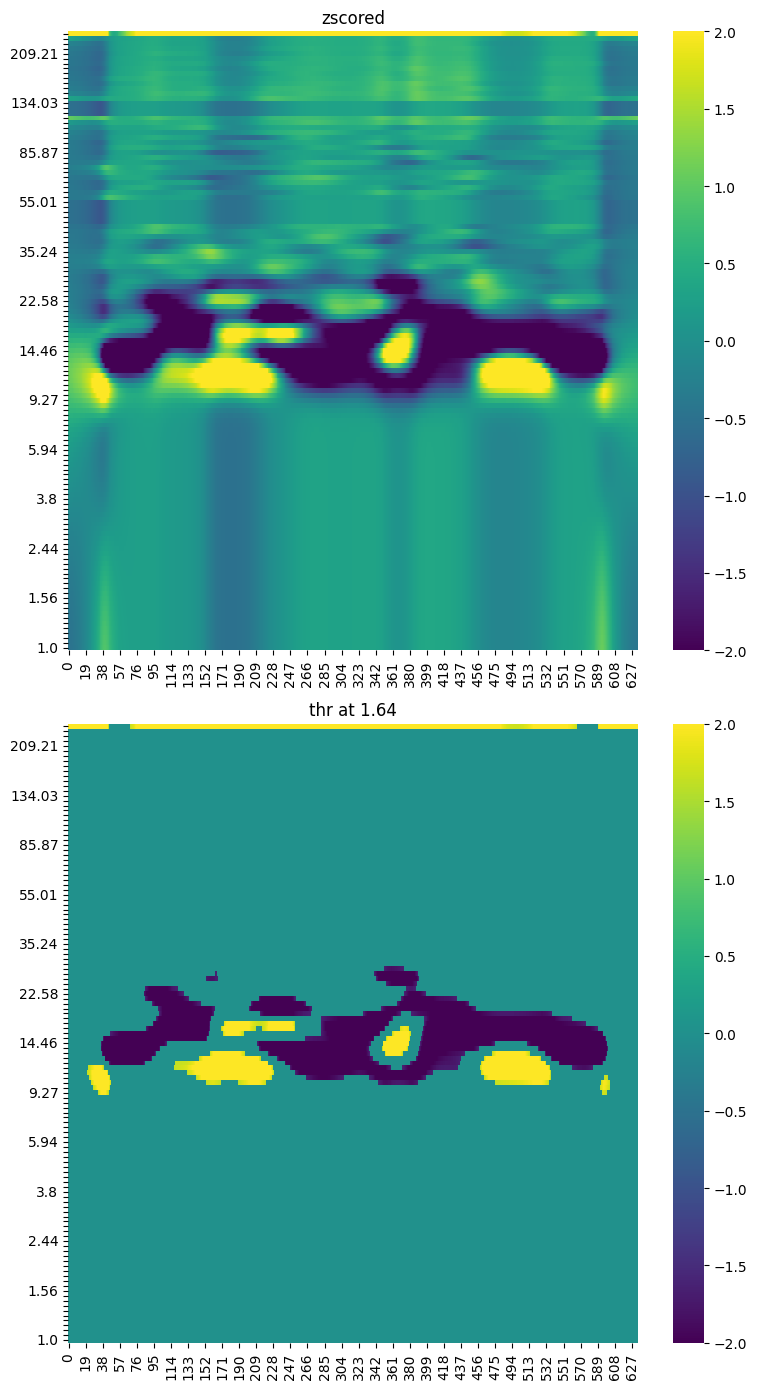

In [82]:
a, b, c, d, e = get_fif_give_zmat('sub22', 5, sel_chans)

Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses13_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses13_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.50
- Lower transition 

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


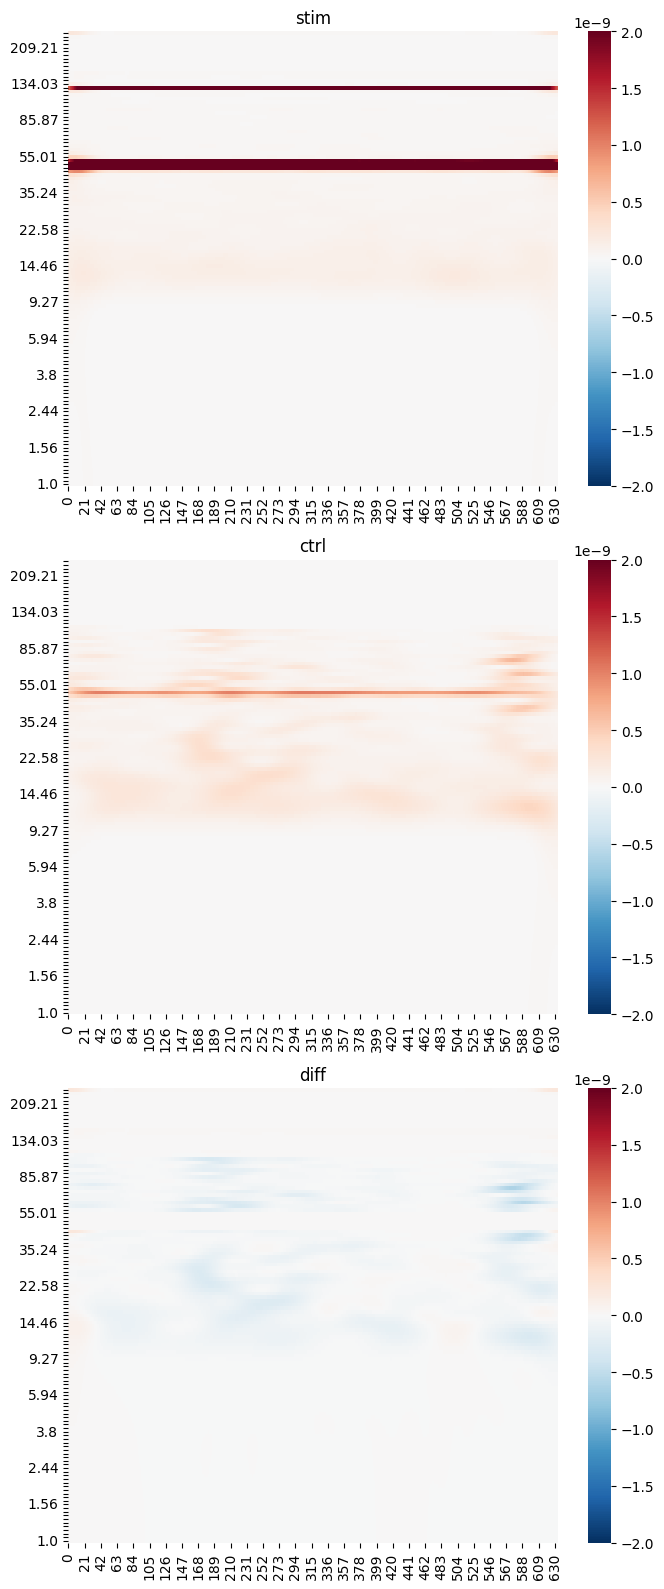

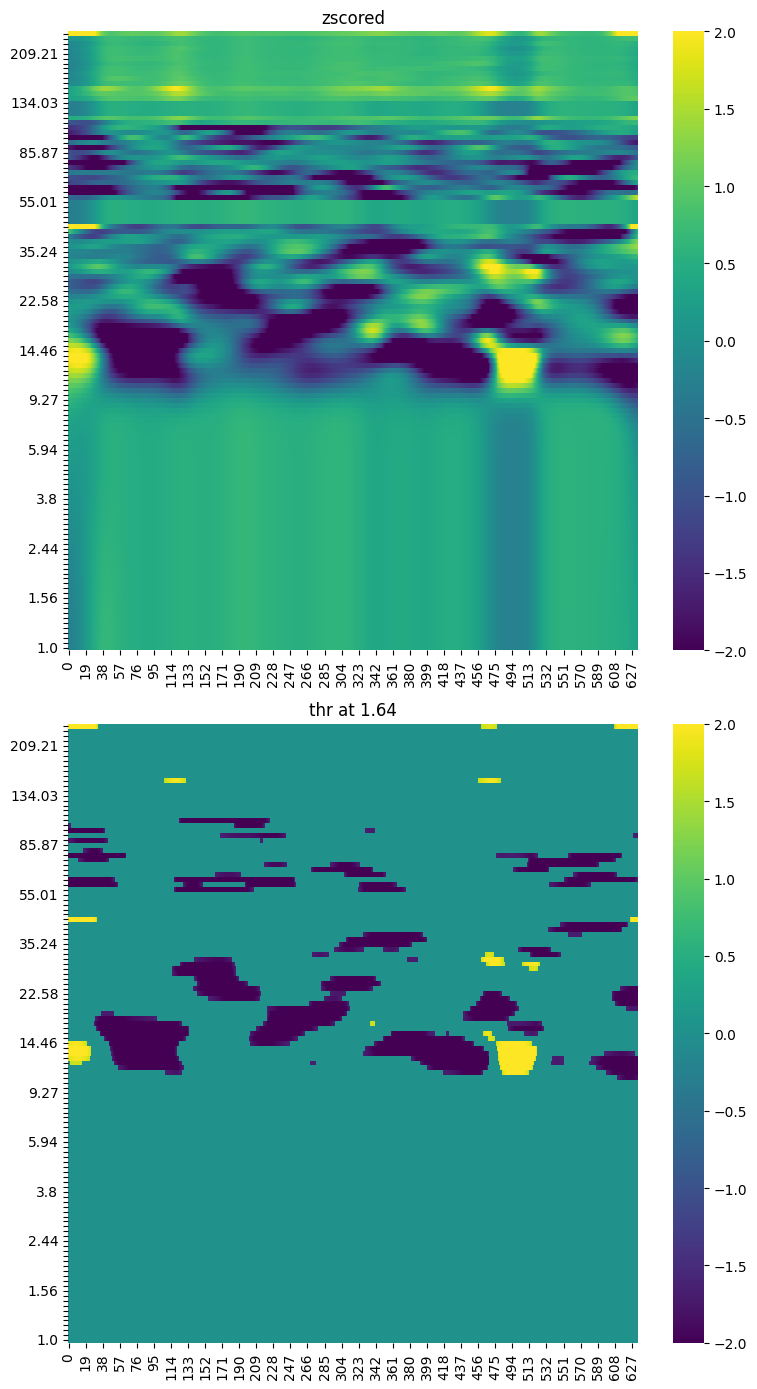

In [83]:
a, b, c, d, e = get_fif_give_zmat('sub22', 12, sel_chans)

Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses00_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses00_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.50
- Lower transition 

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


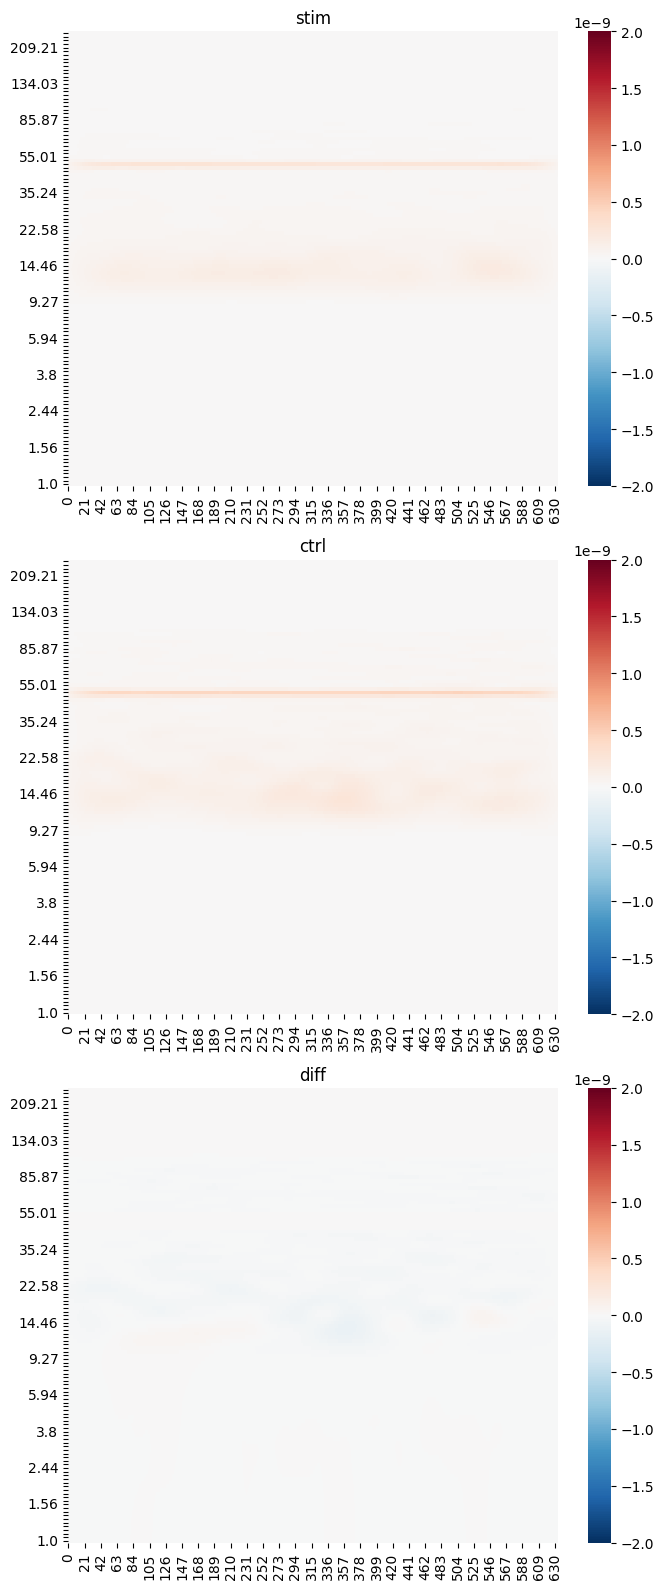

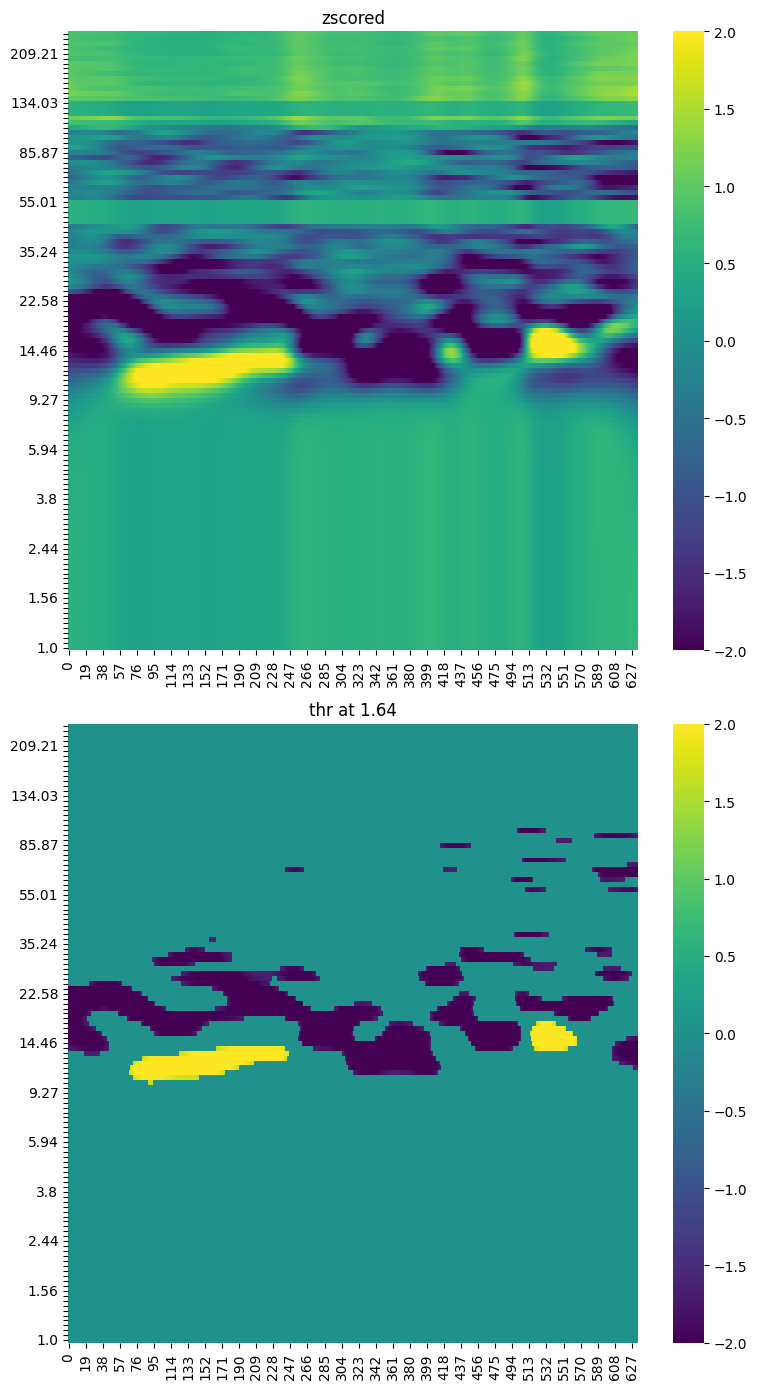

In [84]:
a, b, c, d, e = get_fif_give_zmat('sub22', 0, sel_chans)

# per trial

Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses00_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses00_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.50
- Lower transition 

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Not setting metadata
Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


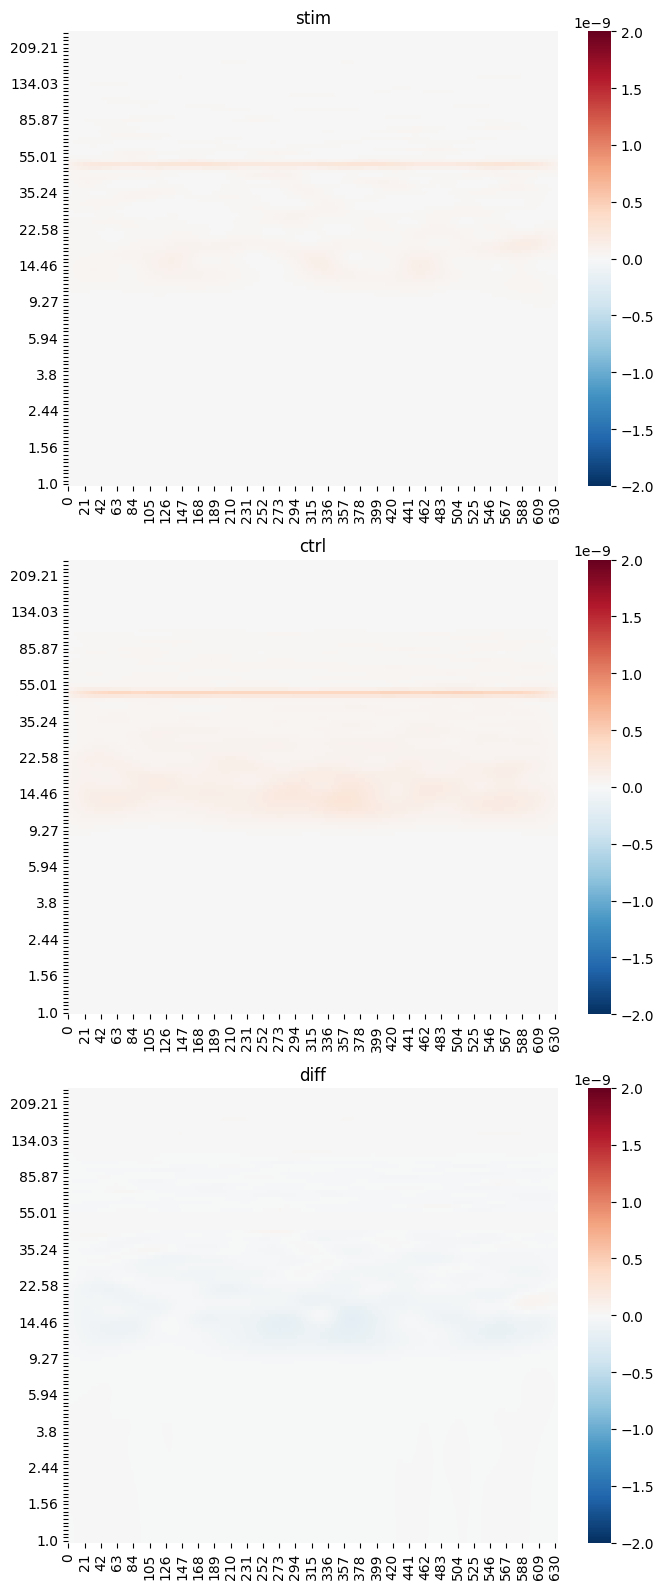

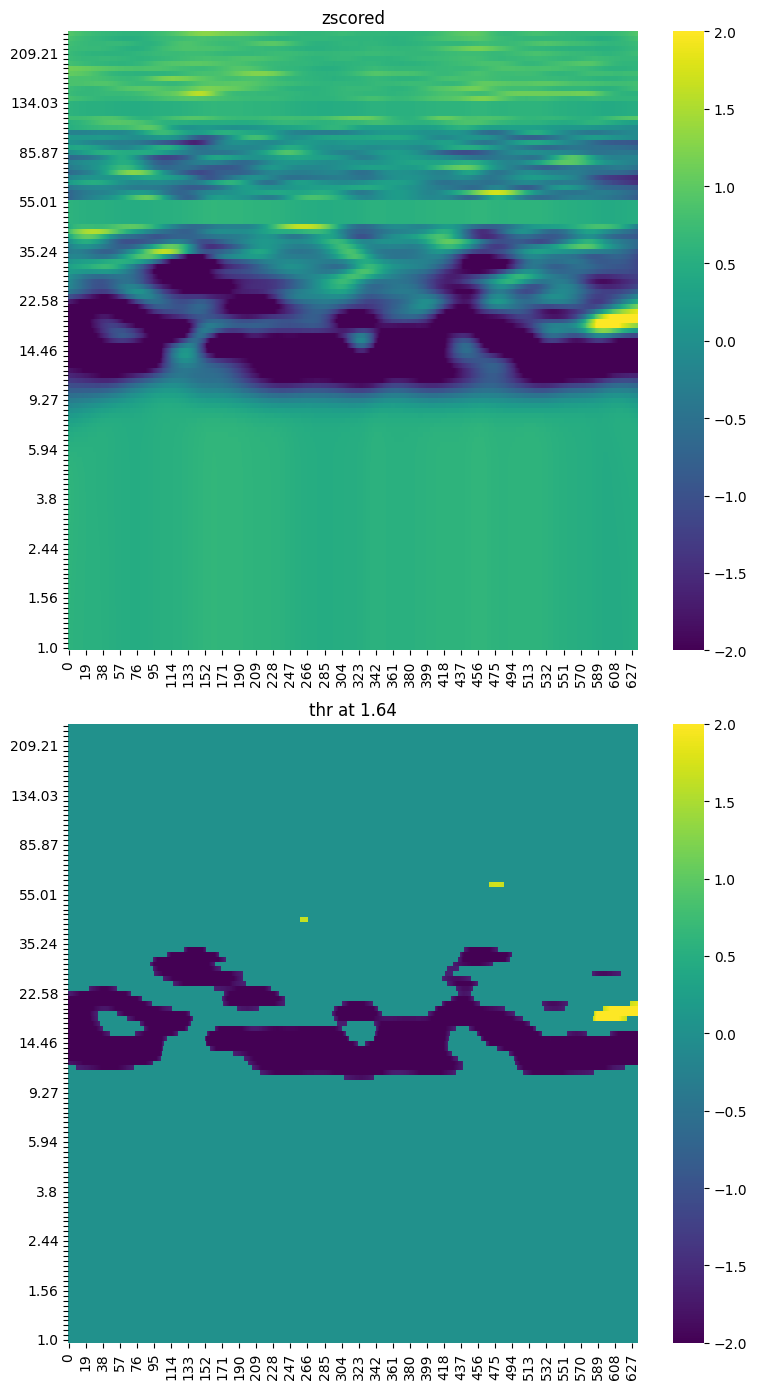

In [85]:
a, b, c, d, e = get_fif_give_zmat('sub22', 0, sel_chans, per_trial=True)

Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses05_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses05_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.50
- Lower transition 

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Not setting metadata
Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


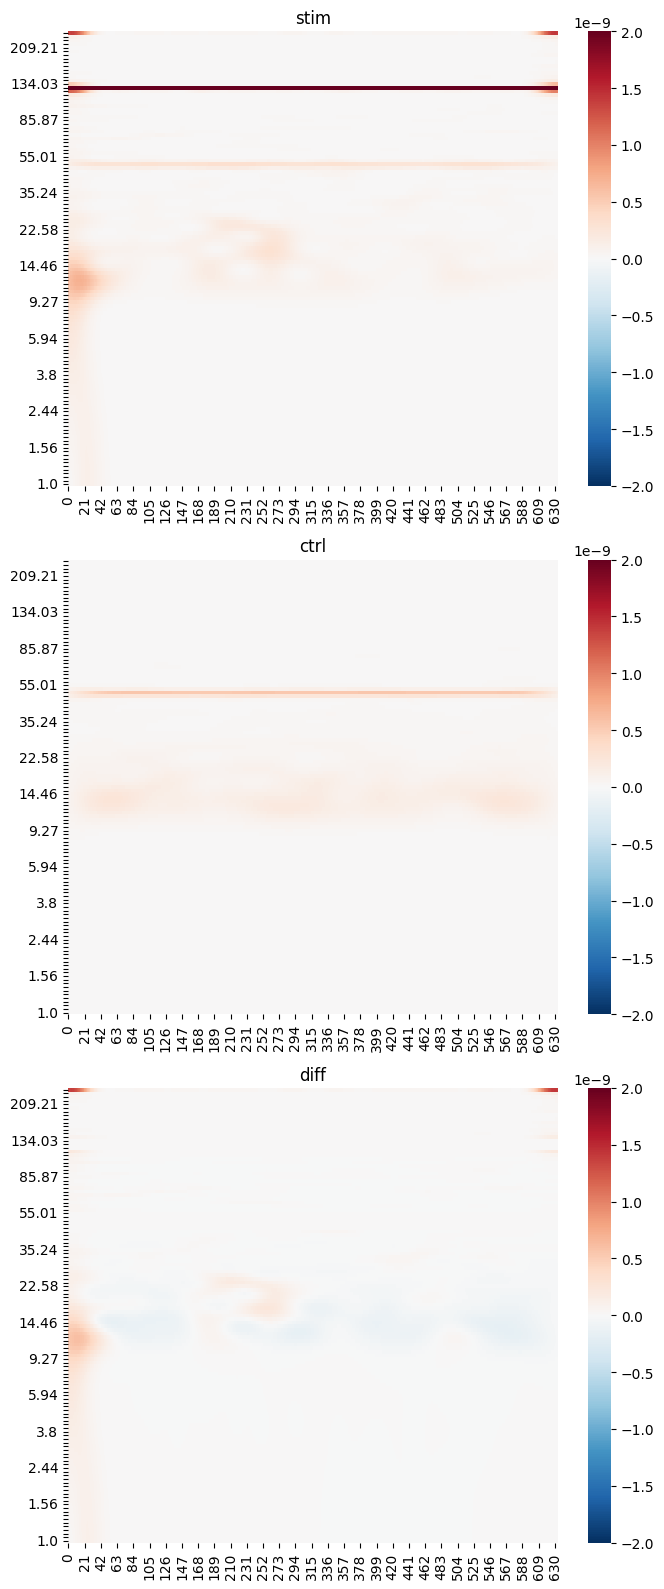

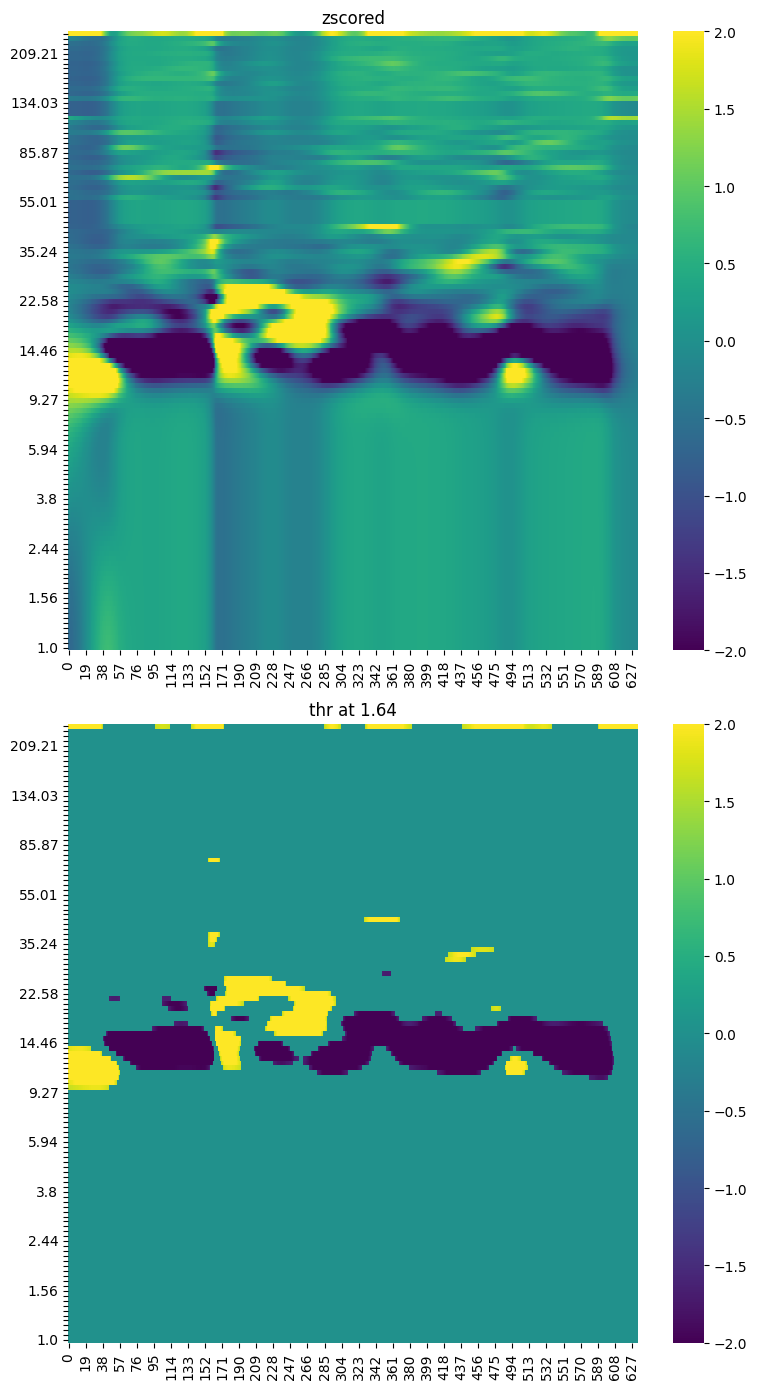

In [86]:
a, b, c, d, e = get_fif_give_zmat('sub22', 5, sel_chans, per_trial=True)

Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses13_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses13_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.50
- Lower transition 

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Not setting metadata
Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


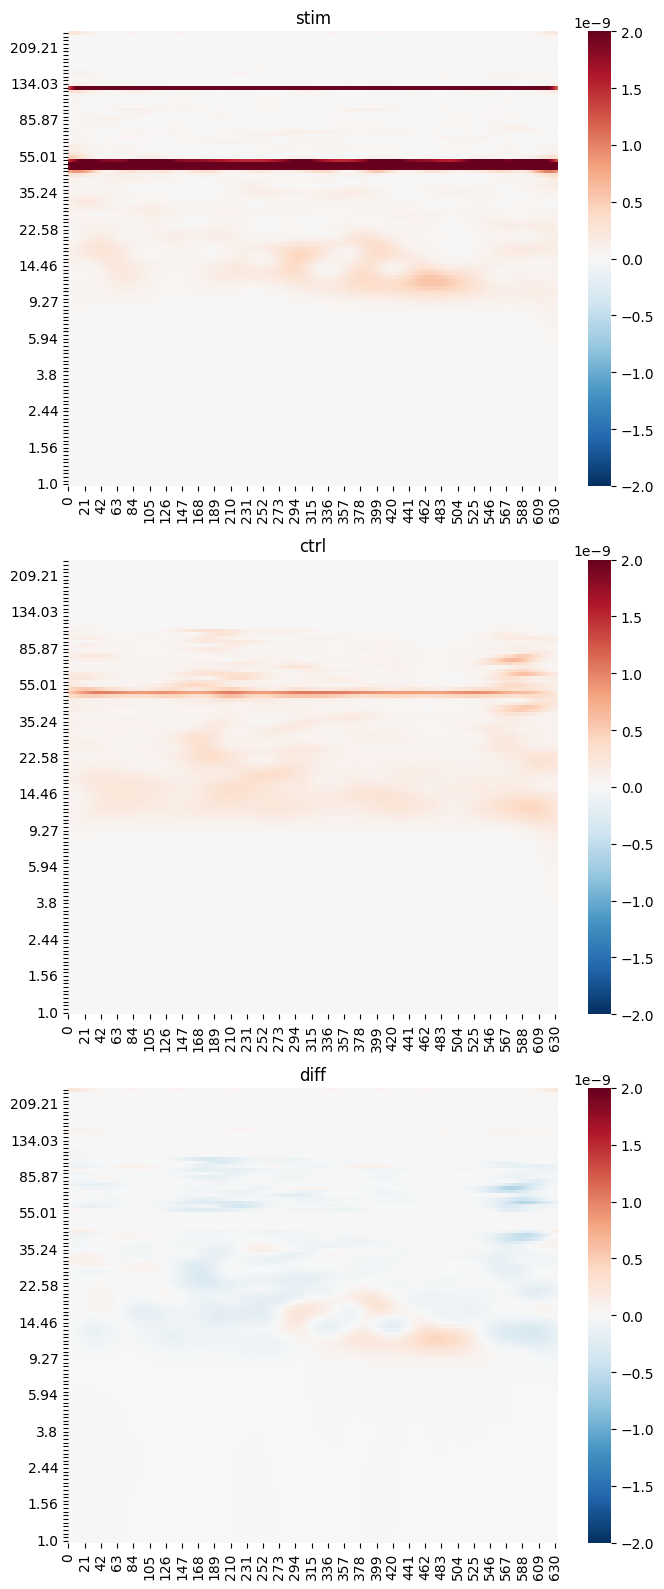

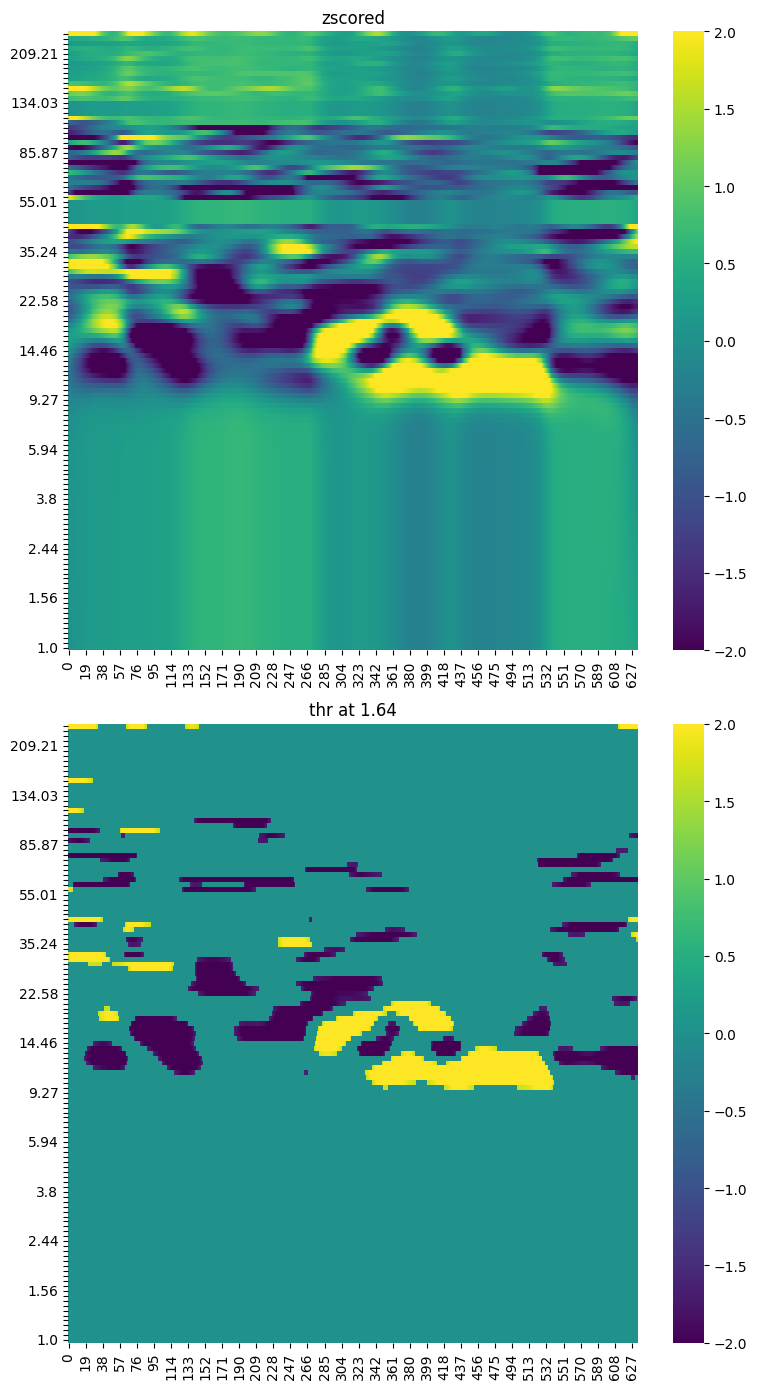

In [87]:
a, b, c, d, e = get_fif_give_zmat('sub22', 12, sel_chans, per_trial=True)

# The stats part

Taking negative values for beta range (12.5 to 30) after thresholding and then getting the curve

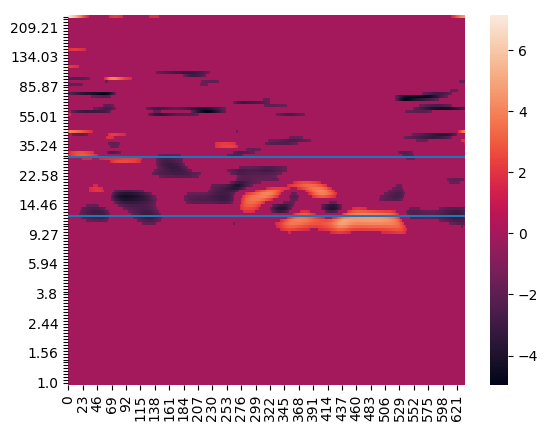

In [104]:
fig, ax = plt.subplots()
sns.heatmap(e, yticklabels=freq_ticks, ax=ax)
ax.invert_yaxis()
ax.axhline(57)
ax.axhline(77)

In [99]:
freqs[57]

12.65548737614331

In [103]:
freqs[77]

30.834960219992194

Indices 57 and 77 map onto beta range

In [109]:
def get_beta_change(zdiff_mat):
    b_change = zdiff_mat[57:77].sum()
    return b_change

# Looping

In [127]:
all_subs = ['sub22', 'sub26']

beta_change_per_int = dict()
all_the_good_stuff = dict()

for sub in all_subs:
    task_eps_fnames = sorted(glob.glob(processed_dir + f'/{sub}*2-epo.fif'))
    beta_change_per_int[sub] = dict()
    all_the_good_stuff[sub] = dict()
    for ses, i in enumerate(task_eps_fnames):
        print(f'Doing {sub} ses {ses}')
        
        all_the_good_stuff[sub][ses] = dict()
        base_mat, task_mat, diff, z_mat, z_mat_thr = get_fif_give_zmat(sub, ses, sel_chans, plot=False)
        for mat_type in ['base_mat', 'task_mat', 'diff', 'z_mat', 'z_mat_thr']:
            all_the_good_stuff[sub][ses][mat_type] = eval(mat_type)
        
        beta_change = get_beta_change(z_mat_thr)
        beta_change_per_int[sub][ses] = beta_change

Doing sub22 ses 0
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses00_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses00_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.50
-

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub22 ses 1
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses01_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses01_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
-----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub22 ses 2
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses02_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses02_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
-----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub22 ses 3
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses03_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses03_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
-----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub22 ses 4
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses04_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses04_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
-----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub22 ses 5
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses05_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses05_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
-----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub22 ses 6
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses06_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses06_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
-----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub22 ses 7
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses07_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses07_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
-----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub22 ses 8
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses08_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses08_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
-----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub22 ses 9
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses09_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses09_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
-----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub22 ses 10
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses10_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses10_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub22 ses 11
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses11_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses11_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub22 ses 12
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses13_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses13_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub26 ses 0
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub26_ses00_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub26_ses00_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
-----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub26 ses 1
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub26_ses01_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub26_ses01_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
-----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub26 ses 2
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub26_ses02_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub26_ses02_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
-----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub26 ses 3
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub26_ses03_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub26_ses03_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
-----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub26 ses 4
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub26_ses04_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub26_ses04_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
-----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub26 ses 5
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub26_ses05_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub26_ses05_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
-----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub26 ses 6
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub26_ses06_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub26_ses06_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
-----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub26 ses 7
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub26_ses07_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub26_ses07_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
-----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub26 ses 8
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub26_ses08_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub26_ses08_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
-----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub26 ses 9
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub26_ses09_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub26_ses09_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
-----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8
Doing sub26 ses 10
Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub26_ses10_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub26_ses10_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
----

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


In [129]:
save_dir = r'G:\My Drive\Lab\other_projects\bme1500\tfr_mats'

with open(save_dir+'\mats_all.pkl', 'wb') as f:
    pickle.dump(all_the_good_stuff, f)
    
with open(save_dir+'\_beta_changes.pkl', 'wb') as f:
    pickle.dump(beta_change_per_int, f)

# Pretty plots

In [131]:
beta_change_per_int

{'sub22': {0: -11175.68691254834,
  1: -3956.10567046702,
  2: -14256.400908801823,
  3: -12913.165339364221,
  4: -4193.222182002295,
  5: -10623.424764030542,
  6: -7444.486029135314,
  7: -6160.280997321126,
  8: -7281.678836417913,
  9: -4575.168322334563,
  10: -5625.557084803448,
  11: -2571.8443816070385,
  12: -8017.954491462951},
 'sub26': {0: -14566.365164141274,
  1: -17037.078746734325,
  2: -17157.12918176312,
  3: -1953.0687469710078,
  4: -16731.99000410358,
  5: 3502.134563598949,
  6: -12711.172759779887,
  7: -14744.262975495261,
  8: -554.6410002544969,
  9: -10221.427215069765,
  10: -5444.554661392589}}

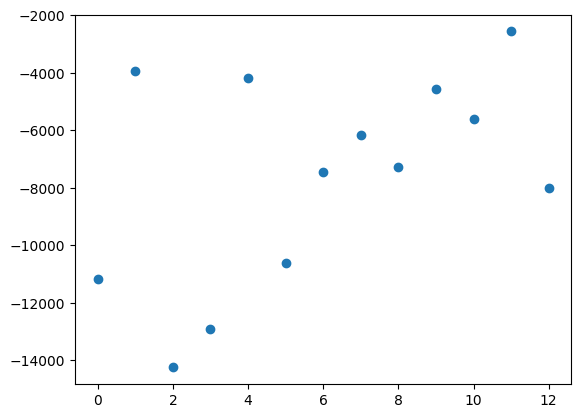

In [146]:
v = beta_change_per_int['sub22']

x_ax = list(v.keys())
x_ax

y_ax = []
for ses in x_ax:
    y_ax.append(v[ses])

plt.scatter(x_ax, y_ax);

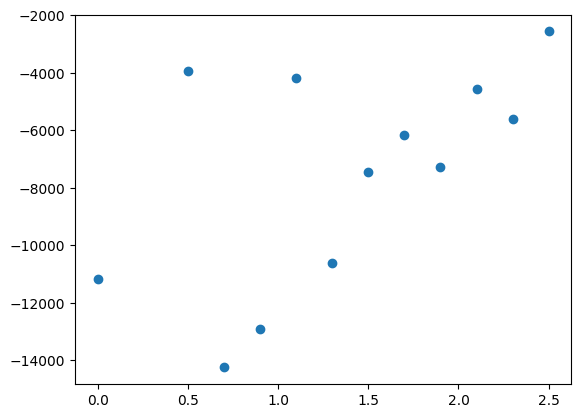

In [147]:
plt.scatter(x_int, y_ax[:-1]);

In [142]:
x_int = [0, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5]

In [145]:
len(x_ax)

13

In [144]:
len(x_int)

12

In [150]:
mat = all_the_good_stuff['sub26'][0]['z_mat_thr']

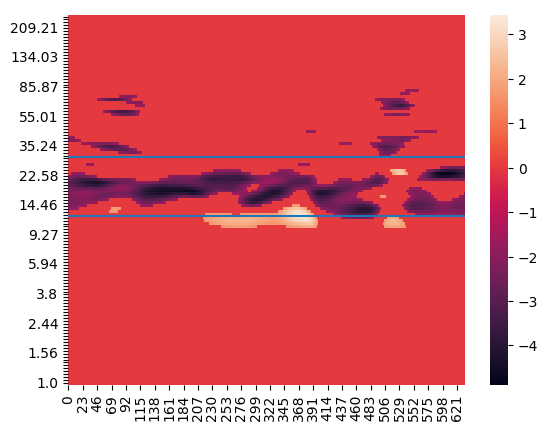

In [151]:
fig, ax = plt.subplots()
sns.heatmap(mat, yticklabels=freq_ticks, ax=ax)
ax.invert_yaxis()
ax.axhline(57)
ax.axhline(77)

In [157]:
beta_change_vs_ses0 = dict()
ctrl_mat = all_the_good_stuff['sub22'][0]['base_mat']
for ses in all_the_good_stuff['sub22'].keys():
    cond_mat = all_the_good_stuff['sub22'][ses]['task_mat']
    diff = get_diff(cond_mat, ctrl_mat)
    _, zdiff = zscore_and_thresh(diff)
    beta_change_vs_ses0[ses] = get_beta_change(diff)

In [153]:
all_the_good_stuff['sub26'][0].keys()

dict_keys(['base_mat', 'task_mat', 'diff', 'z_mat', 'z_mat_thr'])

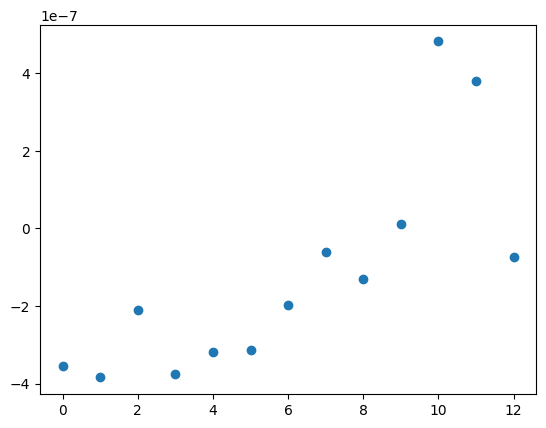

In [158]:
# v = beta_change_per_int['sub22']
v = beta_change_vs_ses0

x_ax = list(v.keys())
x_ax

y_ax = []
for ses in x_ax:
    y_ax.append(v[ses])

plt.scatter(x_ax, y_ax);

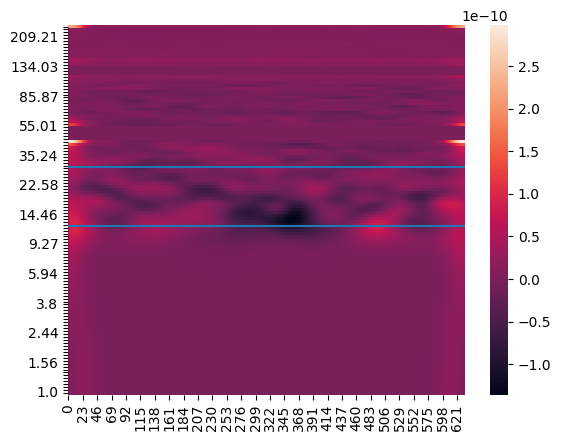

In [159]:
fig, ax = plt.subplots()
sns.heatmap(diff, yticklabels=freq_ticks, ax=ax)
ax.invert_yaxis()
ax.axhline(57)
ax.axhline(77)

Opening raw data file G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses00_baseline-raw.fif...
    Range : 0 ... 20000 =      0.000 ...    20.000 secs
Ready.
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading G:\My Drive\Lab\other_projects\bme1500\preprocessed_final\sub22_ses00_final_2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
Loading data for 10 events and 1901 original time points ...
1 bad epochs dropped
Setting up high-pass filter at 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.50
- Lower transition 

C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


C:\Users\Parsa\AppData\Local\Temp\ipykernel_10712\2479848109.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=False, # wtf is n_cycle?


Working on channel FC5, 0
Working on channel FC1, 1
Working on channel C3, 2
Working on channel CP5, 3
Working on channel CP1, 4
Working on channel FC3, 5
Working on channel C5, 6
Working on channel C1, 7
Working on channel CP3, 8


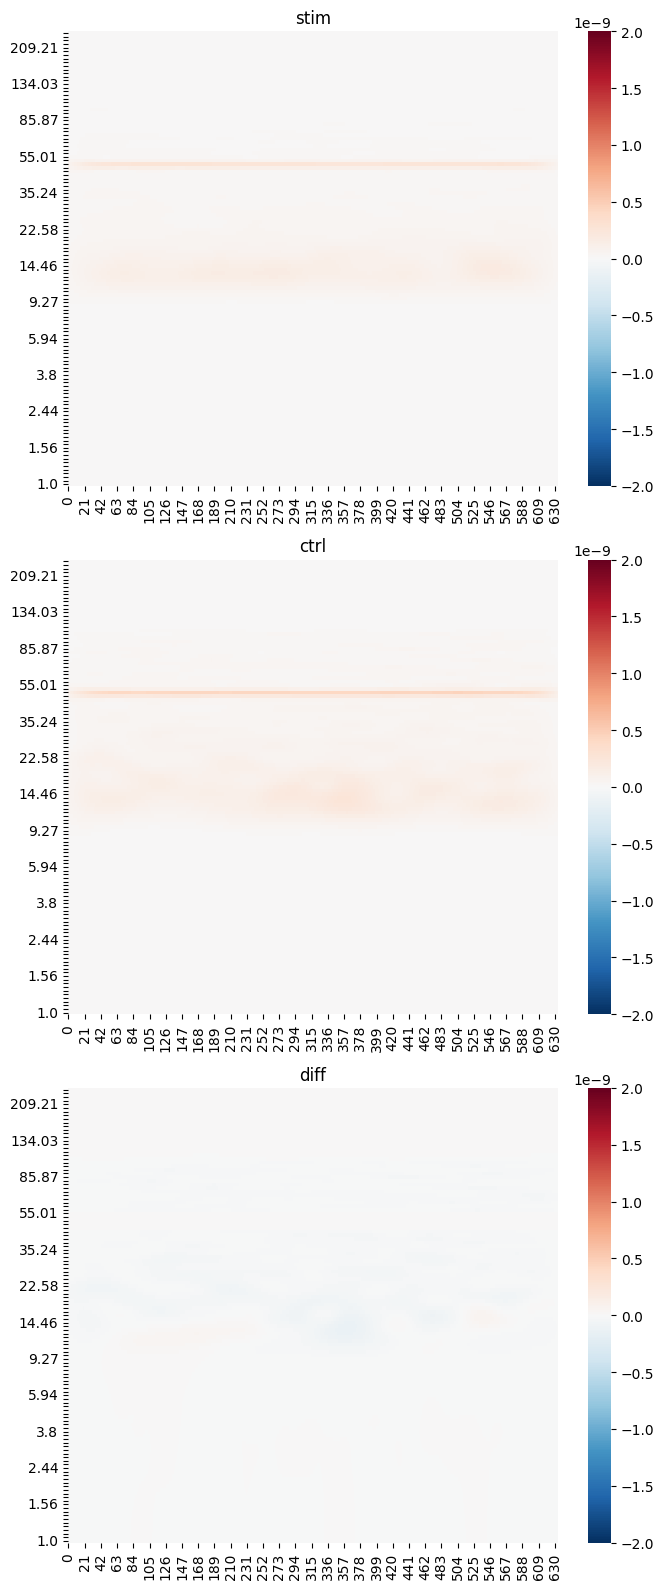

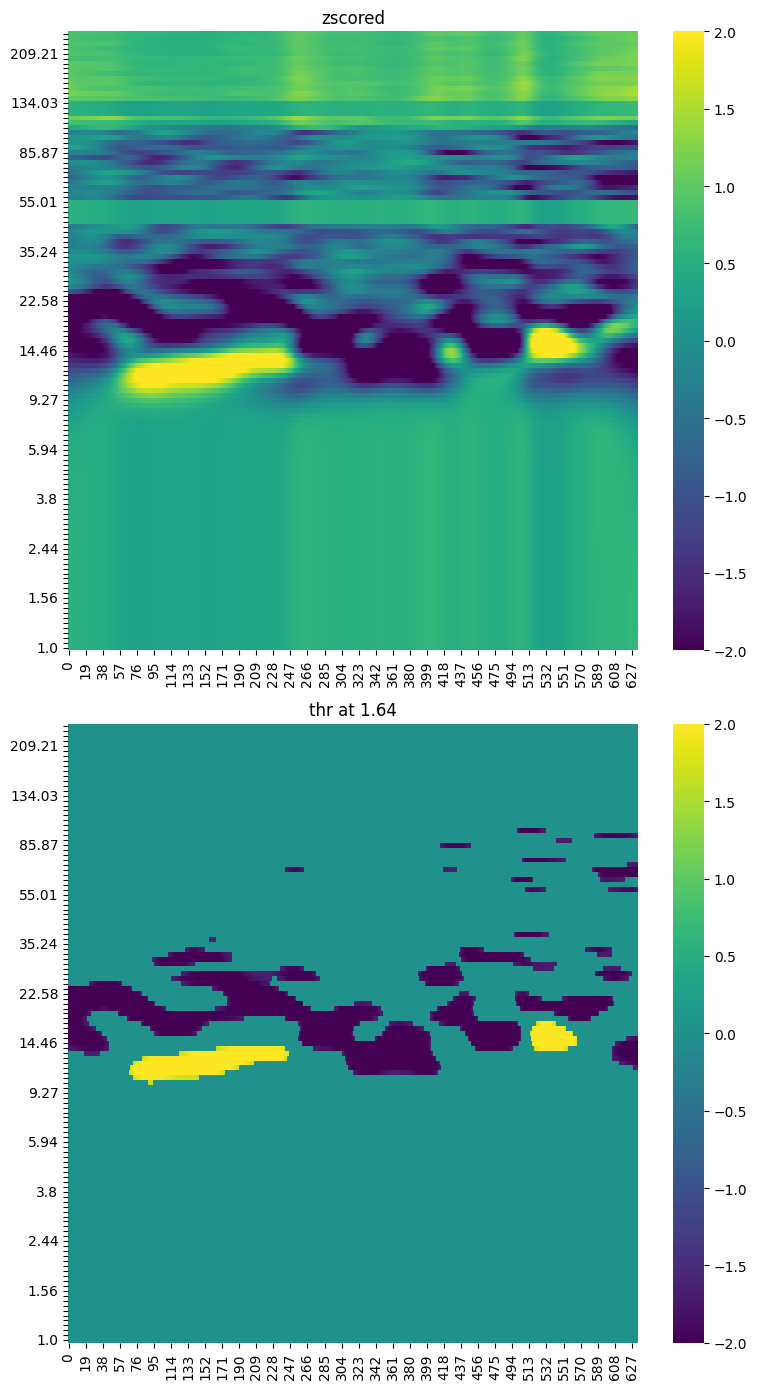

In [162]:
_, ctrl_mat, _, _, _ = get_fif_give_zmat(sub='sub22', ses=0, sel_chans=sel_chans, plot=True)

In [164]:
difff = get_diff(ctrl_mat, ctrl_mat, freqs=freqs, plot=False, tfr_kwargs=tfr_kwargs)

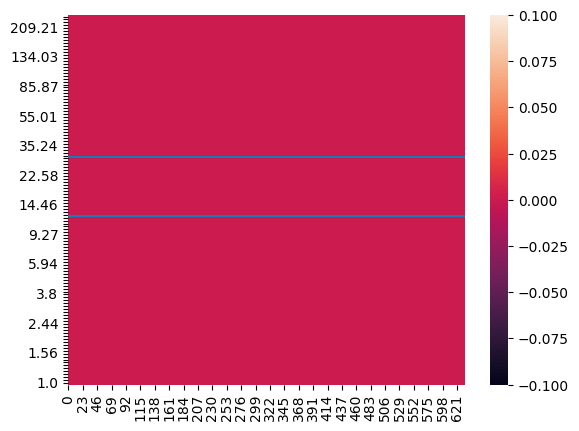

In [165]:
fig, ax = plt.subplots()
sns.heatmap(difff, yticklabels=freq_ticks, ax=ax)
ax.invert_yaxis()
ax.axhline(57)
ax.axhline(77)

In [184]:
beta_change_vs_ses0 = dict()
beta_change_vs_ses0_zdiff = dict()
ctrl_mat = all_the_good_stuff['sub22'][0]['task_mat']
for ses in all_the_good_stuff['sub22'].keys():
    cond_mat = all_the_good_stuff['sub22'][ses]['task_mat']
    diff = get_diff(cond_mat, ctrl_mat)
    _, zdiff = zscore_and_thresh(diff)
    beta_change_vs_ses0[ses] = get_beta_change(diff)
    beta_change_vs_ses0_zdiff[ses] = get_beta_change(zdiff)

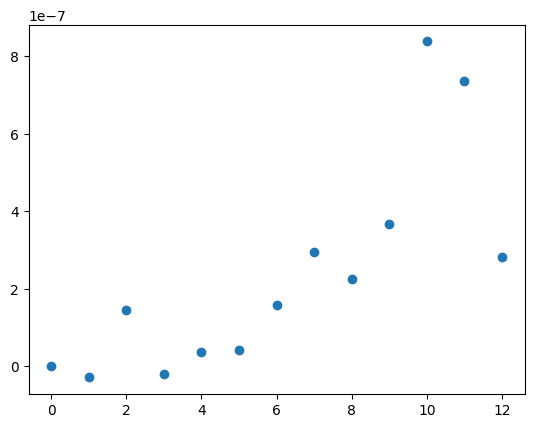

In [185]:
# v = beta_change_per_int['sub22']
v = beta_change_vs_ses0

x_ax = list(v.keys())
x_ax

y_ax = []
for ses in x_ax:
    y_ax.append(v[ses])

plt.scatter(x_ax, y_ax);

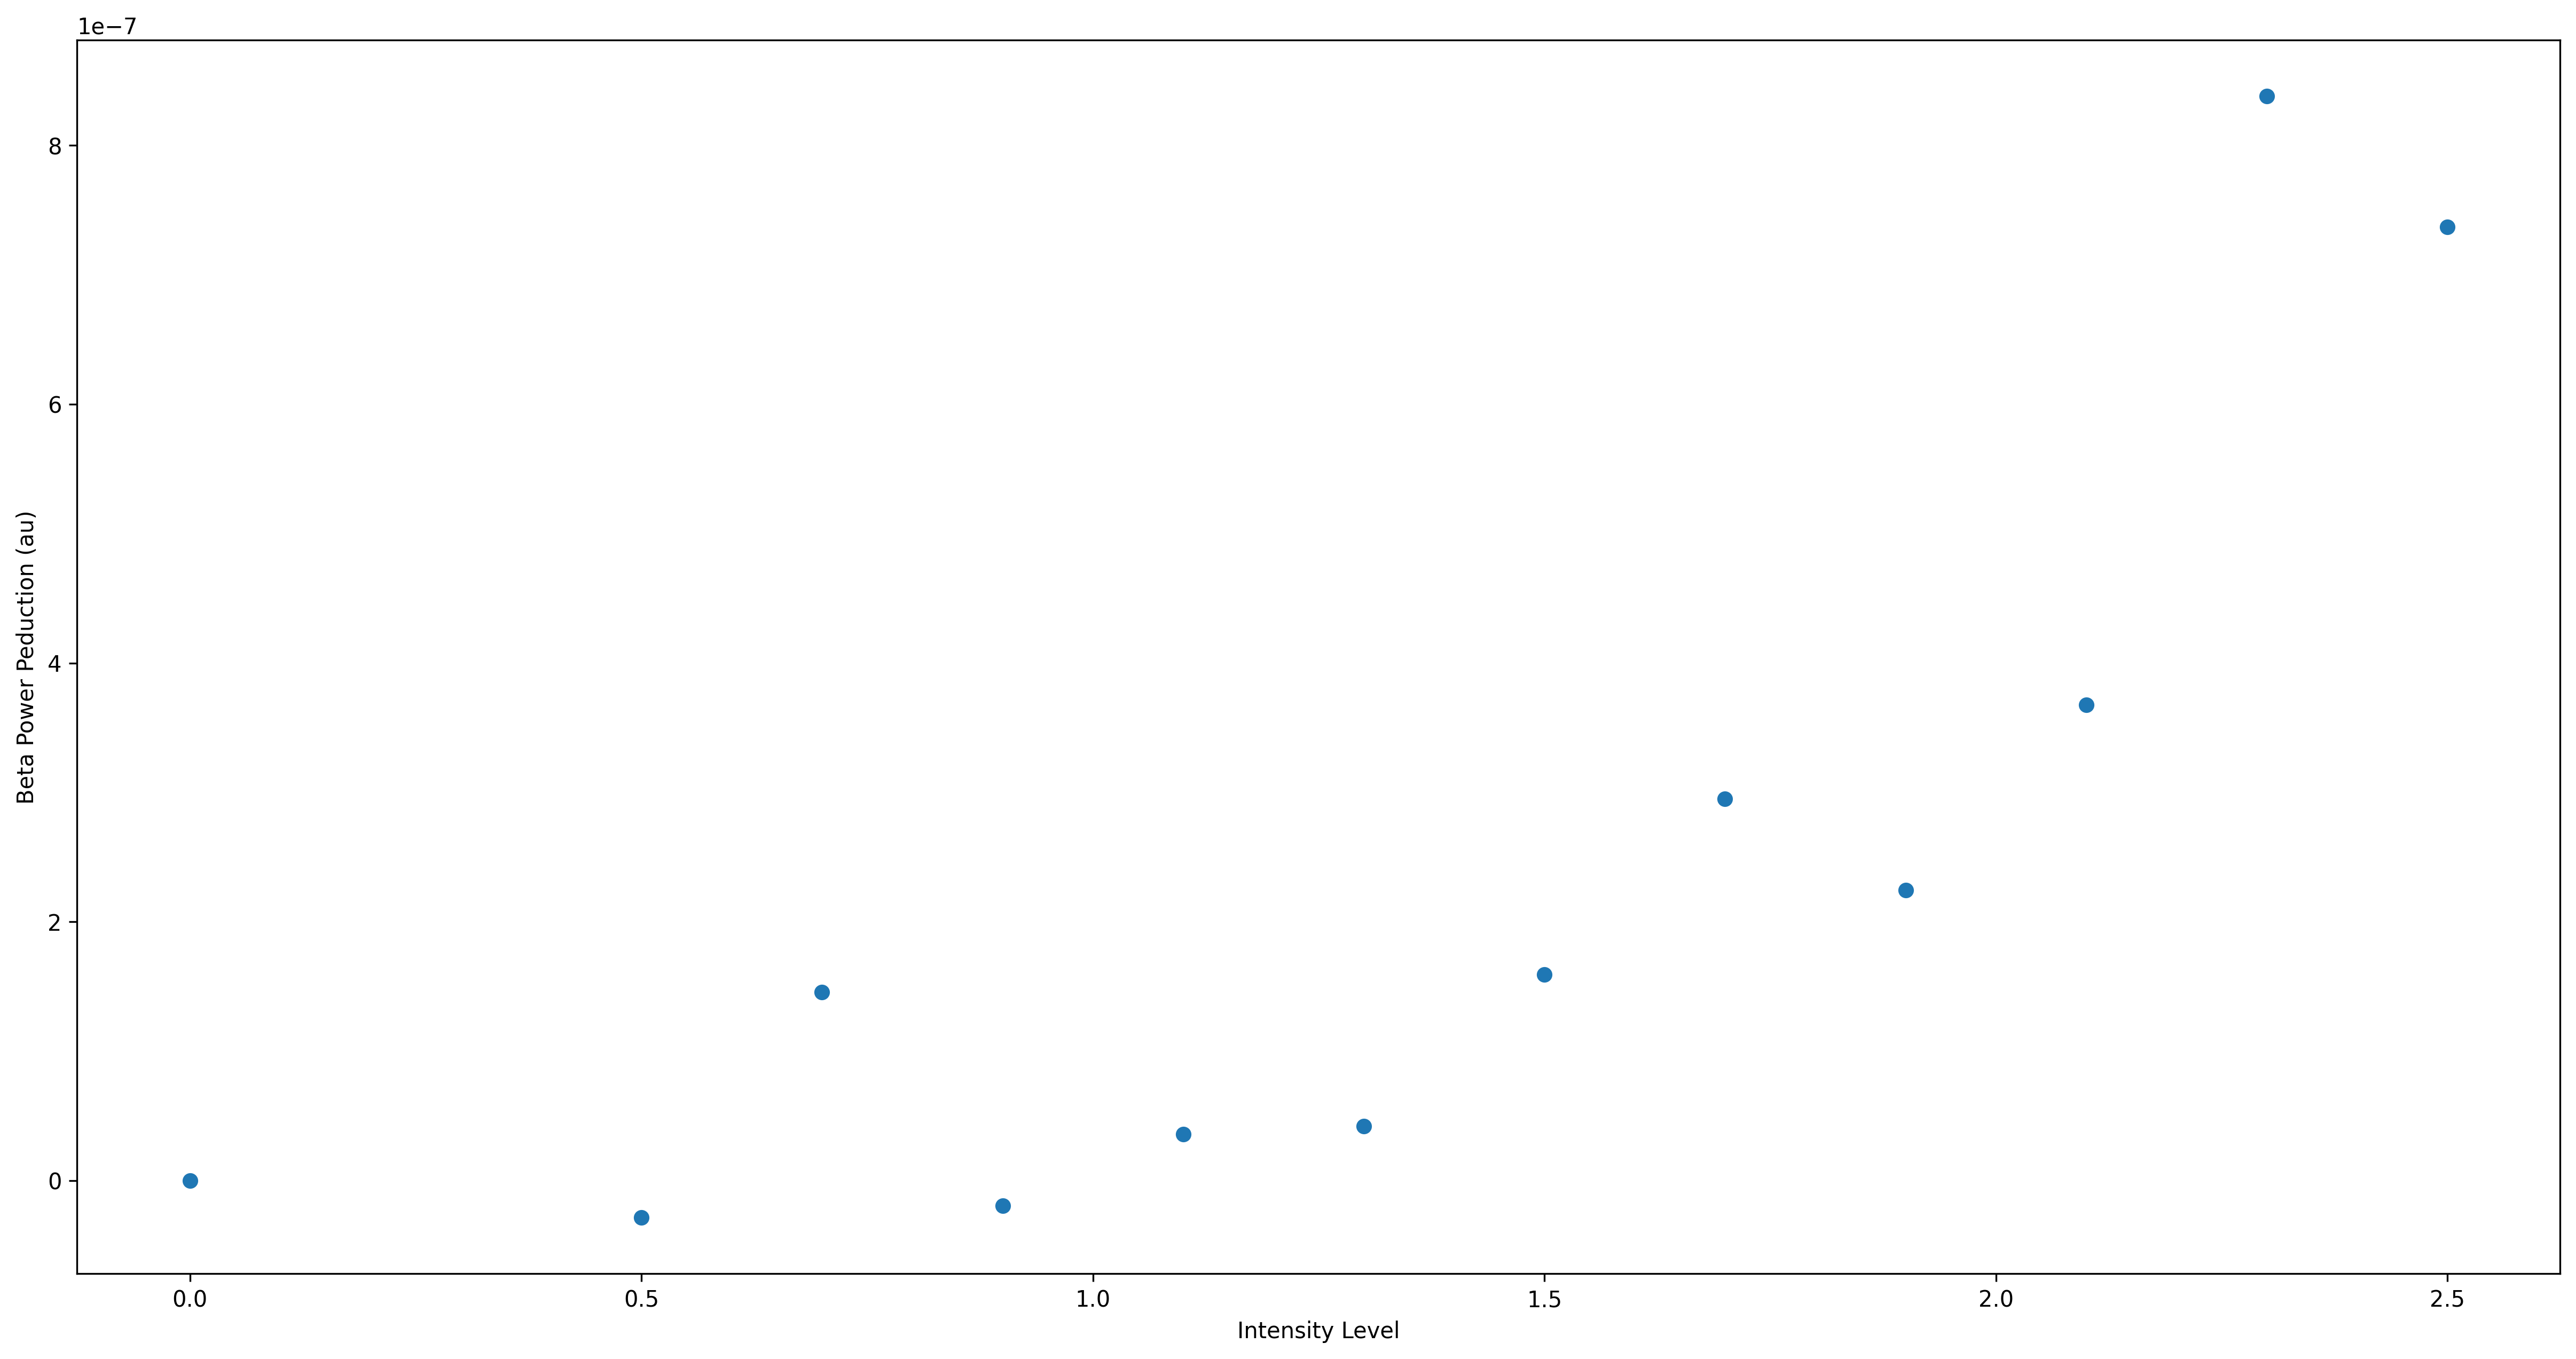

In [186]:
plt.figure(figsize=(20,10), dpi=300)


plt.scatter(x_int, y_ax[:-1]);
plt.ylabel('Beta Power Peduction (au)')
plt.xlabel('Intensity Level')

plt.savefig('sub22_tfr_beta_reduction.png')

In [197]:
x26_int = [0, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 0.5, 0.7, 0.9, 1.1]

In [191]:
len(y_ax)

11

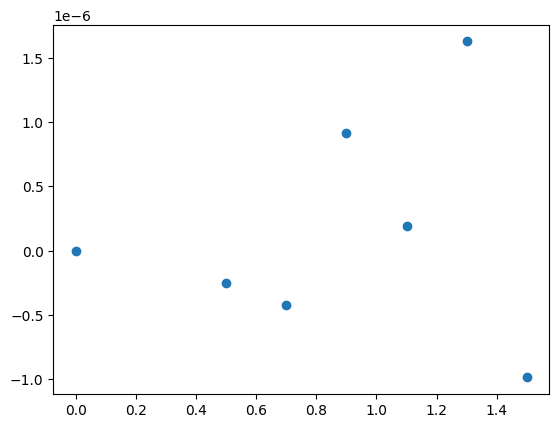

In [200]:
beta_change_vs_ses0_26 = dict()
beta_change_vs_ses0_zdiff_26 = dict()
ctrl_mat = all_the_good_stuff['sub26'][0]['task_mat']
for ses in all_the_good_stuff['sub26'].keys():
    cond_mat = all_the_good_stuff['sub26'][ses]['task_mat']
    diff = get_diff(cond_mat, ctrl_mat)
    _, zdiff = zscore_and_thresh(diff)
    beta_change_vs_ses0_26[ses] = get_beta_change(diff)
    beta_change_vs_ses0_zdiff_26[ses] = get_beta_change(zdiff)
    
# v = beta_change_per_int['sub22']
v = beta_change_vs_ses0_26

x_ax = list(v.keys())
x_ax

y_ax = []
for ses in x_ax:
    y_ax.append(v[ses])

plt.scatter(x26_int[:7], y_ax[:7]);

In [204]:
y_ax

[0.0,
 -2.517479531205053e-07,
 -4.1877605921976444e-07,
 9.184376520642588e-07,
 1.8996317398527477e-07,
 1.6274978376239026e-06,
 -9.863943509490219e-07,
 7.89750842896453e-07,
 -1.875211390616414e-08,
 -8.731734156236252e-07,
 1.0922655584909119e-07]

In [205]:
from numpy import mean

x26_int = [0, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 0.5, 0.7, 0.9, 1.1]
intensity_list=[[0, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 0.5, 0.7, 0.9, 1.1]]

j = 0


v = beta_change_vs_ses0_26

x_ax = list(v.keys())
x_ax

y_ax = []
for ses in x_ax:
    y_ax.append(v[ses])
score_list = [y_ax]

num_patient=1

final_intensity =  [[] for _ in range(num_patient)]
final_score = [[] for _ in range(num_patient)]

for pos,i in enumerate(intensity_list[j]):
        arr = np.array(intensity_list[j])
        res = np.where(arr==i)[0]
        if len(res)==1:
            final_intensity[j].append(i)
            final_score[j].append(score_list[j][pos])
        else:
            exist = final_intensity[j].count(i)
            if exist == 0:
                temp = []
                for k in res:
                    temp.append(score_list[j][k])
                final_score[j].append(mean(temp))
                final_intensity[j].append(i)

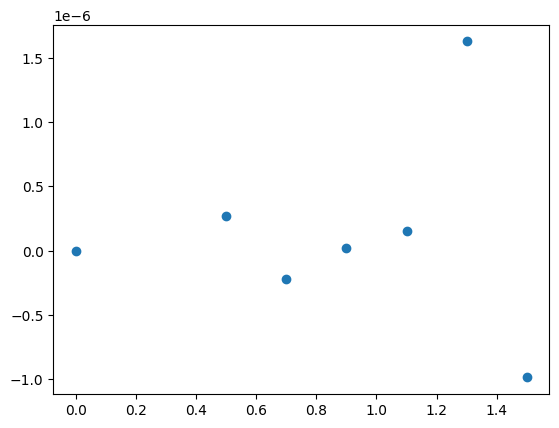

In [206]:
plt.scatter(final_intensity[0],final_score[0]);

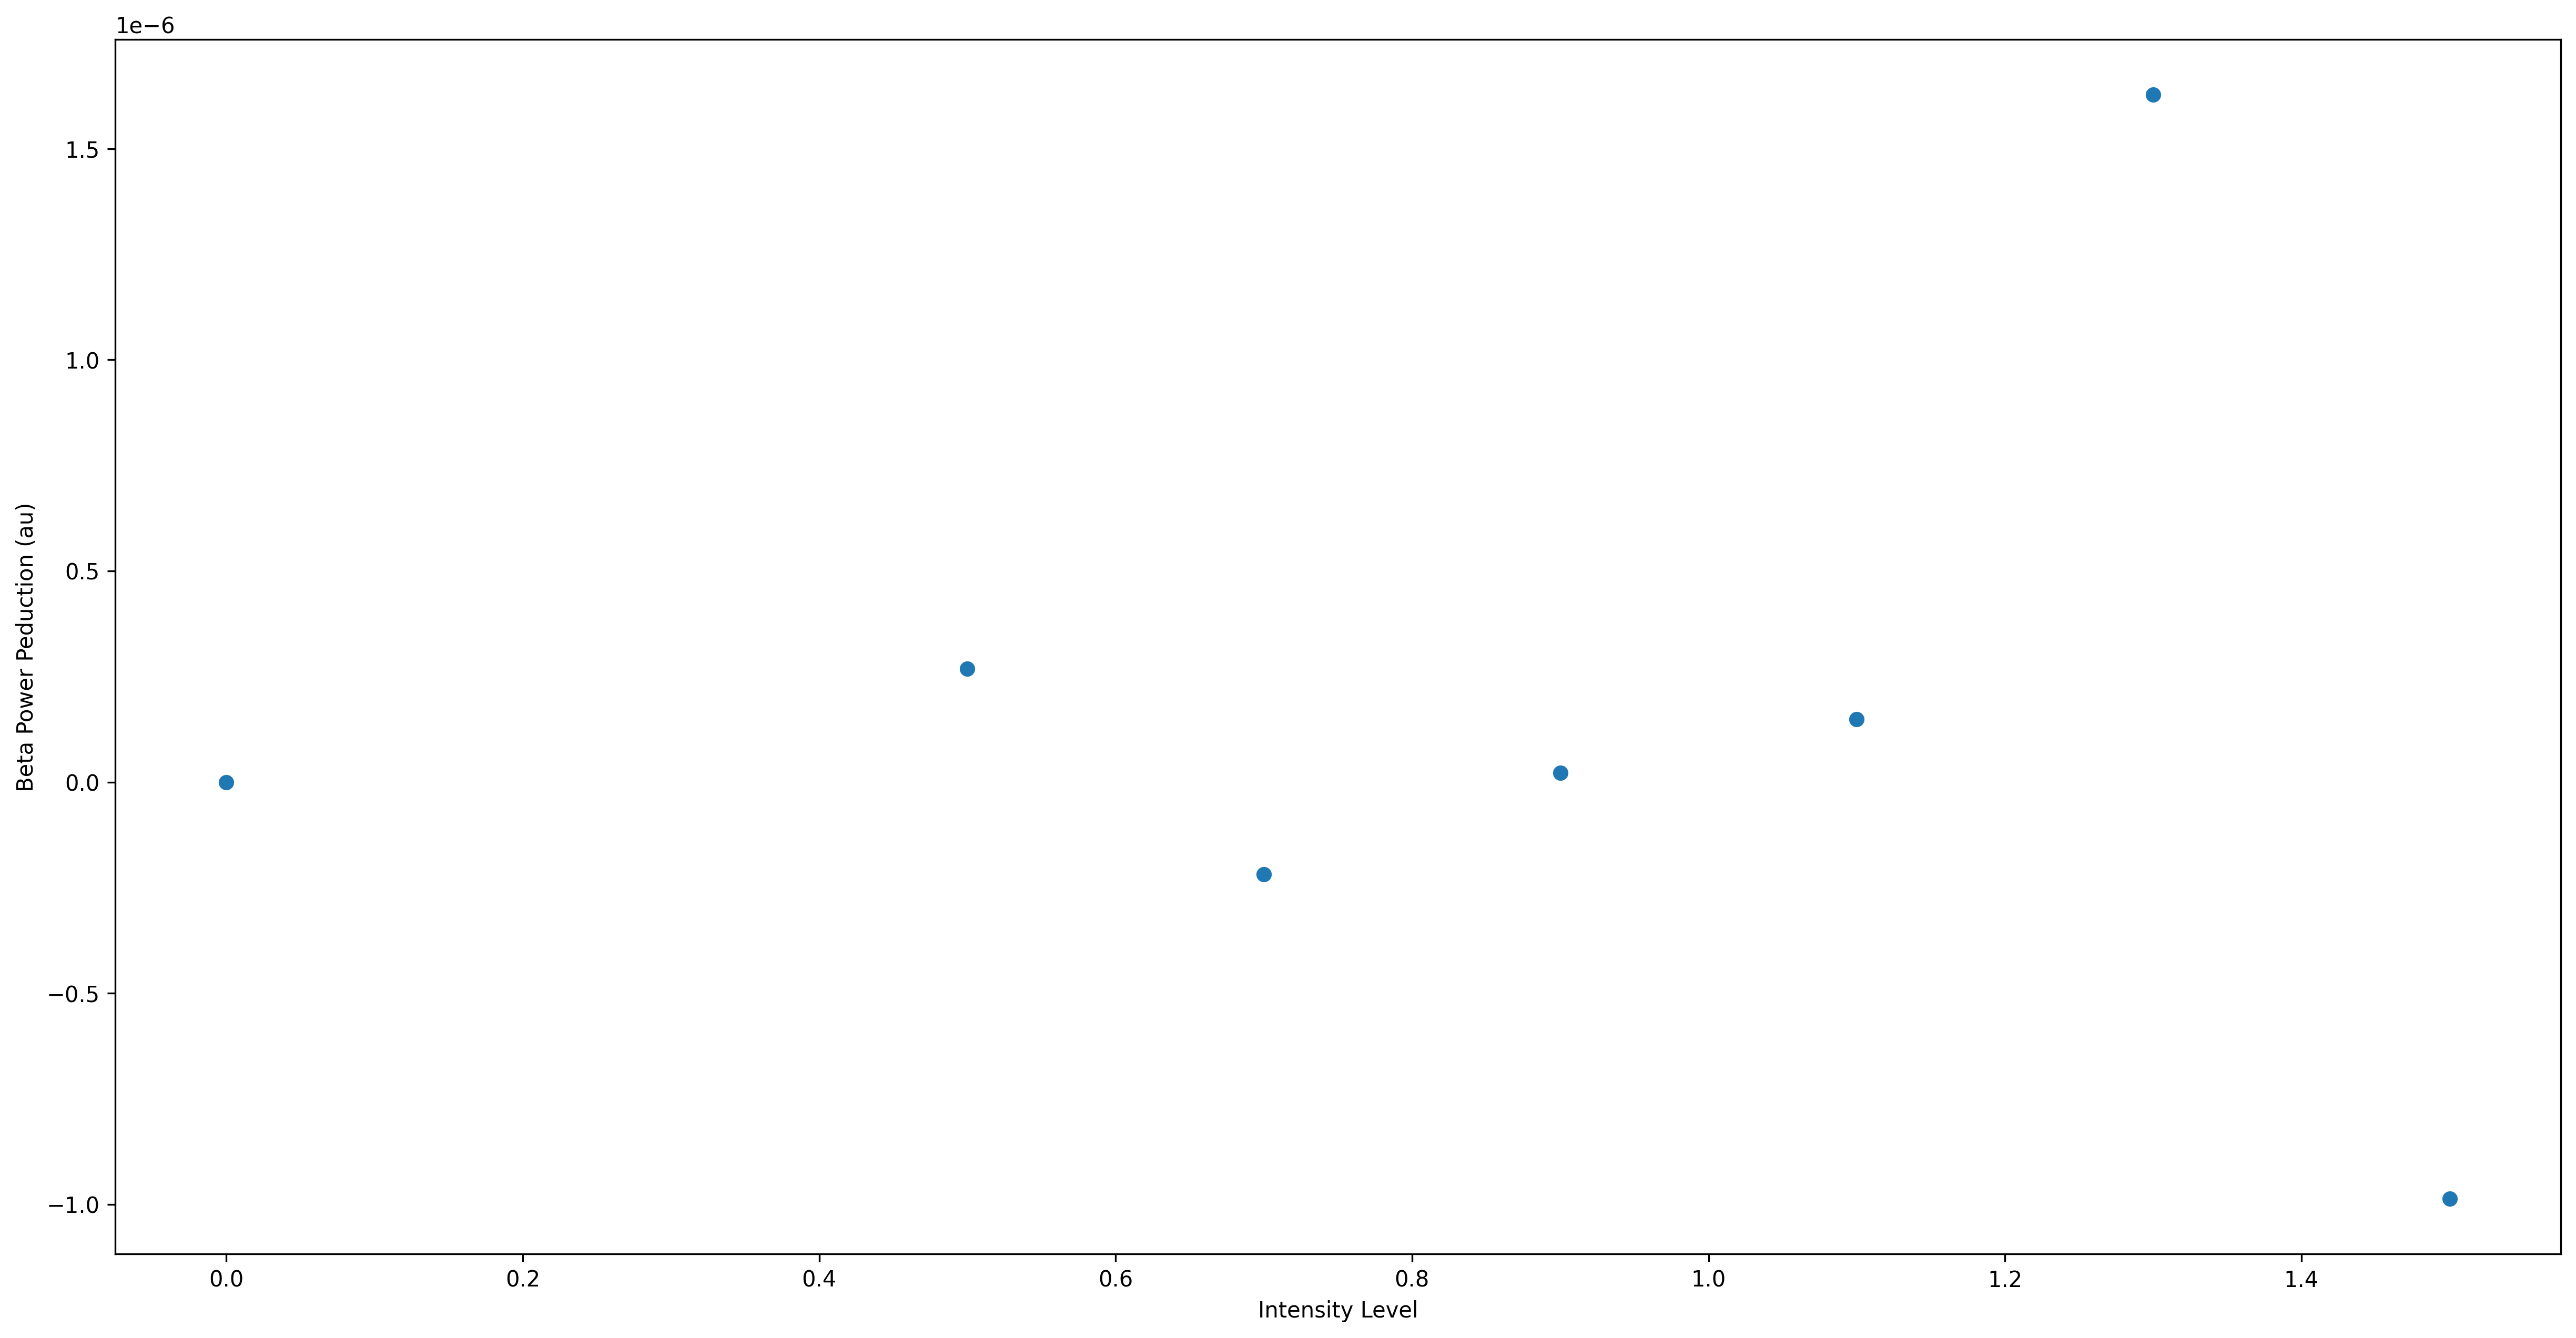

In [207]:
plt.figure(figsize=(20,10), dpi=300)


plt.scatter(final_intensity[0],final_score[0]);
plt.ylabel('Beta Power Peduction (au)')
plt.xlabel('Intensity Level')

plt.savefig('sub26_tfr_beta_reduction.png')